In [ ]:
import pickle
import pprint
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [ ]:
%matplotlib inline

In [ ]:

def load_pickles():
    difft_file = open("results-difft.pickle", "rb")
    gt_file = open("results-GT.pickle", "rb")

    difft = pickle.load(difft_file)
    GT = pickle.load(gt_file)

    return {"GT": GT, "difft": difft}


def setup(n_mut):
    res = [0] * n_mut
    count = [0] * n_mut
    mut_res = {}
    mut_count = {}

    return {"res": res, "count": count, "mut_res": mut_res, "mut_count": mut_count}


def remove_mut_operators(diff_results, operators):
    for diff_tool in diff_results:
        for contract in diff_results[diff_tool]:
            for i in range(len(diff_results[diff_tool][contract])):
                for r in operators:
                    if r in diff_results[diff_tool][contract][i].keys():
                        diff_results[diff_tool][contract][i].pop(r)


def analyze_diffs(diffs, res_dict, n_mut):
    is_GT = isinstance(next(iter(next(iter(diffs.values()))[0].values())), list)

    for contract in diffs:
        for i in range(len(diffs[contract])):
            for mut in diffs[contract][i]:
                if not diffs[contract][i][mut] == []:
                    res_dict["count"][i] += 1
                    if is_GT:
                        res_dict["res"][i] += diffs[contract][i][mut][0]
                    else:
                        res_dict["res"][i] += diffs[contract][i][mut]
                    
                    if not mut in res_dict["mut_res"].keys():
                        res_dict["mut_res"][mut] = [0] * n_mut
                        res_dict["mut_count"][mut] = [0] * n_mut 

                    if is_GT:
                        res_dict["mut_res"][mut][i] += diffs[contract][i][mut][0]
                    else:
                        res_dict["mut_res"][mut][i] += diffs[contract][i][mut] 
                    res_dict["mut_count"][mut][i] += 1    

    #Calculate average results 
    res_dict["res"] = [i / j for i, j in zip( res_dict["res"],  res_dict["count"])]

    for mut in res_dict["mut_res"]:
        for i in range(len(np.trim_zeros( res_dict["mut_res"][mut]))):
            res_dict["mut_res"][mut] = np.trim_zeros( res_dict["mut_res"][mut])
            res_dict["mut_count"][mut] = np.trim_zeros( res_dict["mut_count"][mut])
            res_dict["mut_res"][mut][i] /= res_dict["mut_count"][mut][i]


def print_summary(GT, difft):
    print("====================================")
    print("difftastic average: " + str(difft["res"]))
    print("successful # of mutations: ", difft["count"])
    print("Gumtree average: " + str(GT["res"]))
    print("successful # of mutations: ", GT["count"])
    print("====================================")


    plt.bar(x = [1,2,3,4,5,6,7,8,9,10], height = difft["count"], color = 'b')
    plt.xticks([1,2,3,4,5,6,7,8,9,10])
    plt.title("Number of Times X Amount of Mutations Could be Applied to Files")
    plt.xlabel("Number of Mutations")
    plt.ylabel("Successful Mutations")
    plt.show()


def print_by_mutation(res_dict):
    
    print("EDIT SCRIPT LENGTH BY MUTATION:")
    print("=====================================================")
    mut_sorted = sorted(res_dict["mut_res"].items(), key = lambda x: x[1][len(x[1])-1])
    for mut in mut_sorted:
        print(mut[0], mut[1], " counts:", res_dict["mut_res"][mut[0]])
    print("=====================================================")


def save_as_csv(filename):
    with open(filename, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter= " ", quotechar='|')
        for key in GT_res_dict["mut_res"]:
            writer.writerow([key] + GT_res_dict["mut_res"][key])
        writer.writerow("           ")
        for key in difft_res_dict["mut_res"]:
            writer.writerow([key] + difft_res_dict["mut_res"][key])


def scatter_with_avg_plot(GT, difft):
    plt.plot(range(10) ,difft["res"], label=("difft_avg"), color="blue")
    for mut in difft["mut_res"]:
        x = [i+0.985 for i in range(len(difft["mut_res"][mut]))]
        plt.scatter(x, difft["mut_res"][mut], color="blue", s=6)

    plt.plot(range(10), GT["res"], label ="GT_avg", color = "red")
    for mut in GT["mut_res"]:
        x = [i+1.015 for i in range(len(GT["mut_res"][mut]))]
        plt.scatter(x, GT["mut_res"][mut], color="red", s=6)

    plt.title("Average Edit Distance per Mutation and Tool")
    plt.ylabel("Edit actions")
    plt.xlabel("Number of mutations")
    plt.minorticks_on()
    plt.xticks(range(11))
    plt.legend()
    plt.show()


def box_plot(data, offset):
    box(data[0], offset, "green")
    box(data[1], -offset, "blue")

    green_patch = mpatches.Patch(color="green", label="Gumtree")
    blue_patch = mpatches.Patch(color="blue", label="Difftastic")
    plt.legend(handles=[green_patch, blue_patch])

    x = [1,2,3,4,5,6,7,8,9,10]
    plt.ylabel("Edit actions")
    plt.xlabel("Number of mutations")
    plt.xticks(x, labels=x)
    #plt.title("Edit Distances")
    plt.show()


def box(data, offset, color):
    d = [[] for _ in range(10)]
    for key in data.keys():
        for i in range(len(data[key])):
            d[i].append(data[key][i])
    
    x = [x - offset for x in [1,2,3,4,5,6,7,8,9,10]]
   
    plt.boxplot(d, widths=0.27, patch_artist=True,
        positions=x,
        showmeans=True, showfliers=False,
        medianprops={"color": "white", "linewidth": 1},
        boxprops={"facecolor":  color, "edgecolor": "black",
                  "linewidth": 0.25},
        whiskerprops={"color": color, "linewidth": 1},
        meanprops={"markerfacecolor": color, "markeredgecolor": "black"},
        capprops={"color": color, "linewidth": 1})


def bar_by_mut_plot(data, offset, oper, title):
    
    fig, ax = plt.subplots(layout='constrained')

    bar(data[0], -offset, "green", ax, oper)
    bar(data[1], offset, "blue", ax, oper)

    red_patch = mpatches.Patch(color="lime", label="Gumtree")
    blue_patch = mpatches.Patch(color="b", label="Difftastic")
    plt.legend(handles=[red_patch, blue_patch])
    
    plt.title(title)
    plt.show()


def bar(data, offset, color, subplot, oper):  
    greens = ['#85ff66', '#79e759', '#6cd04c', '#60b940', '#53a334', '#478d29', '#3a781e', '#2e6413', '#225009', '#173d00']

    blues = ['#75ffff', '#4ae3f4', '#0bc6e8', '#00aada', '#008dca', '#0071b6', '#0056a2', '#003b8b', '#071f70', '#140052']


    colors = "none"
    if color == "blue":
        colors = blues
    elif color == "green":
        colors = greens

    x = np.arange(len(oper))
    n = 0
    for key in oper:
        plt_data = np.around(data[key], 2)
        for i in range(len(plt_data)-1, -1, -1):
            subplot.bar(x = x[n] + offset, width =  0.25, height = plt_data[i], color = colors[i])
        n += 1
    subplot.set_xticks(x, oper)
    

def calc_corr(data):
    x = [1,2,3,4,5,6,7,8,9,10]
    count = [0 for _ in range(10)]
    
    d = [0 for _ in range(10)]
    for key in data.keys():
        for i in range(len(data[key])):
            d[i] += data[key][i]
            count[i] += 1
    
    res = [i / j for i, j in zip(d, count)]

    r = np.corrcoef(x, res)
    r2 = np.polyfit(x, res, 1)
    print("Slope: ", r2, "\nCorrelation:", r, '\n')        


### Let's use this new version 

In [ ]:
import matplotlib
matplotlib.use('Agg')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these functions are defined elsewhere in your code
# from your_module import load_pickles, remove_mut_operators, setup, analyze_diffs, box_plot, calc_corr, bar_by_mut_plot

num_mut = 10
pickles = load_pickles()

remove_mut_operators(pickles, ["AVR", "SCEC"])

GT_res_dict = setup(num_mut)
analyze_diffs(pickles["GT"], GT_res_dict, num_mut)

difft_res_dict = setup(num_mut)
analyze_diffs(pickles["difft"], difft_res_dict, num_mut)

# Commented out print statements as per original script
# print_summary(GT_res_dict, difft_res_dict)
# print_by_mutation(difft_res_dict)
# print_by_mutation(GT_res_dict)

# scatter_with_avg_plot(GT_res_dict, difft_res_dict)
box_plot((GT_res_dict["mut_res"], difft_res_dict["mut_res"]), 0.15)
plt.title('')  # Remove title
plt.savefig('figures/edit_distances.pdf', format='pdf', bbox_inches='tight')  # Save the box plot as PDF
plt.savefig('figures/edit_distances.svg', format='svg', bbox_inches='tight')  # Save the box plot as PDF

plt.close()  # Close the figure

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
r = np.corrcoef(x, GT_res_dict["res"])
r2 = np.polyfit(x, GT_res_dict["res"], 1)
print("Gumtree slope: ", r2, "\nGumtree correlation:", r, '\n')
calc_corr(GT_res_dict["mut_res"])

r = np.corrcoef(x, difft_res_dict["res"])
r2 = np.polyfit(x, difft_res_dict["res"], 1)
print("difft slope: ", r2, "\ndifft correlation:", r)
calc_corr(difft_res_dict["mut_res"])

# Removed operators due to errors in testing: "AVR", "SCEC"
opers = []
opers.append(["BLR", "HLR", "ILR", "SLR"])
opers.append(["AOR", "BOR", "DOD", "ECS", "ICM", "MCR", "UORD", "VUR"])
opers.append(["CBD", "CCD", "CSC", "EED", "EHC", "OLFD", "ORFD", "RSD"])
opers.append(["ACM", "LSC", "MOC", "MOD", "MOI", "MOR", "RVS"])
opers.append(["BCRD", "DLR", "ER", "ETR", "FVR", "GVR", "PKD", "SFR", "SKD", "SKI", "TOR", "VVR"])
titles = ["Mutated Literals", "Mutated Operators & Type Specifications", "Mutated Code Blocks", "Mutated Arguments & Modifiers", "Other Mutations"]

def configure_plot():
    plt.rc('font', size=14)  # Adjust font size for double-column research paper format
    plt.rc('axes', titlesize=14)  # Larger font size for axes titles
    plt.rc('axes', labelsize=14)  # Larger font size for axes labels
    plt.rc('xtick', labelsize=12)  # Larger font size for x-tick labels
    plt.rc('ytick', labelsize=12)  # Larger font size for y-tick labels
    plt.rc('legend', fontsize=12)  # Larger font size for legend

for i in range(len(opers)):
    configure_plot()
    bar_by_mut_plot((GT_res_dict["mut_res"], difft_res_dict["mut_res"]), 0.15, opers[i], titles[i])
    plt.title('')  # Remove title
    plt.savefig(f'figures/{titles[i].replace(" ", "_")}.pdf', format='pdf', bbox_inches='tight')
    plt.close()  # Close the figure


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these functions are defined elsewhere in your code
# from your_module import load_pickles, remove_mut_operators, setup, analyze_diffs, box_plot, calc_corr, bar_by_mut_plot

num_mut = 10
pickles = load_pickles()

remove_mut_operators(pickles, ["AVR", "SCEC"])

GT_res_dict = setup(num_mut)
analyze_diffs(pickles["GT"], GT_res_dict, num_mut)

difft_res_dict = setup(num_mut)
analyze_diffs(pickles["difft"], difft_res_dict, num_mut)

# Commented out print statements as per original script
# print_summary(GT_res_dict, difft_res_dict)
# print_by_mutation(difft_res_dict)
# print_by_mutation(GT_res_dict)

# scatter_with_avg_plot(GT_res_dict, difft_res_dict)
box_plot((GT_res_dict["mut_res"], difft_res_dict["mut_res"]), 0.15)
plt.title('')  # Remove title
plt.savefig('figures/edit_distances.pdf', format='pdf', bbox_inches='tight')  # Save the box plot as PDF
plt.close()  # Close the figure

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
r = np.corrcoef(x, GT_res_dict["res"])
r2 = np.polyfit(x, GT_res_dict["res"], 1)
print("Gumtree slope: ", r2, "\nGumtree correlation:", r, '\n')
calc_corr(GT_res_dict["mut_res"])

r = np.corrcoef(x, difft_res_dict["res"])
r2 = np.polyfit(x, difft_res_dict["res"], 1)
print("difft slope: ", r2, "\ndifft correlation:", r)
calc_corr(difft_res_dict["mut_res"])

# Removed operators due to errors in testing: "AVR", "SCEC"
opers = []
opers.append(["BLR", "HLR", "ILR", "SLR"])
opers.append(["AOR", "BOR", "DOD", "ECS", "ICM", "MCR", "UORD", "VUR"])
opers.append(["CBD", "CCD", "CSC", "EED", "EHC", "OLFD", "ORFD", "RSD"])
opers.append(["ACM", "LSC", "MOC", "MOD", "MOI", "MOR", "RVS"])
opers.append(["BCRD", "DLR", "ER", "ETR", "FVR", "GVR", "PKD", "SFR", "SKD", "SKI", "TOR", "VVR"])
titles = ["Mutated Literals", "Mutated Operators & Type Specifications", "Mutated Code Blocks", "Mutated Arguments & Modifiers", "Other Mutations"]

def configure_plot():
    plt.rc('font', size=14)  # Adjust font size for double-column research paper format
    plt.rc('axes', titlesize=14)  # Larger font size for axes titles
    plt.rc('axes', labelsize=14)  # Larger font size for axes labels
    plt.rc('xtick', labelsize=12)  # Larger font size for x-tick labels
    plt.rc('ytick', labelsize=12)  # Larger font size for y-tick labels
    plt.rc('legend', fontsize=12)  # Larger font size for legend

for i in range(len(opers)):
    configure_plot()
    bar_by_mut_plot((GT_res_dict["mut_res"], difft_res_dict["mut_res"]), 0.15, opers[i], titles[i])
    plt.xlabel('Mutation operators')  # Add x-axis label
    plt.ylabel('Edit distance')  # Add y-axis label
    plt.title('')  # Remove title
    plt.savefig(f'figures/{titles[i].replace(" ", "_")}.pdf', format='pdf', bbox_inches='tight')
    plt.close()  # Close the figure

In [ ]:
print(f'GT_res_dict.keys(): {GT_res_dict.keys()}')
print(f'GT_res_dict["mut_res"].keys(): {GT_res_dict["mut_res"].keys()}')
print(f'type of GT_res_dict["mut_count"]: {type(GT_res_dict["mut_count"])}')
print(f'type of GT_res_dict["mut_res"]["BLR"]: {type(GT_res_dict["mut_res"]["BLR"])}')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming GT_res_dict and difft_res_dict contain 'mut_res' as lists of values corresponding to mutation operators
def aggregate_values(values):
    """Aggregate the list of values for each operator using the mean."""
    return np.mean(values) if values else 0

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

# Check if combined_data is not empty before proceeding
if not combined_data:
    raise ValueError("No valid data found for plotting.")

# Sort the combined data by the Difftastic results in descending order
combined_data.sort(key=lambda x: x[2], reverse=True)

# Extract sorted values for plotting
operators, gt_values, difft_values, categories = zip(*combined_data)

# Assign colors or patterns to differentiate categories
unique_categories = list(set(categories))
colors = plt.cm.tab20.colors  # A colormap to select colors
category_colors = {cat: colors[i % len(colors)] for i, cat in enumerate(unique_categories)}

# Plotting
plt.figure(figsize=(10, len(operators) * 0.4))  # Adjust figure size for better visibility
plt.barh(operators, difft_values, color=[category_colors[cat] for cat in categories], edgecolor='black')

# Adding category labels as a legend
legend_labels = [plt.Line2D([0], [0], color=category_colors[cat], lw=4) for cat in unique_categories]
plt.legend(legend_labels, unique_categories, title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Edit Distance')
plt.ylabel('Mutation Operators')
plt.title('Combined Edit Distances Sorted by Difftastic Results')
plt.tight_layout()
plt.savefig('figures/combined_edit_distances_sorted.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Assuming GT_res_dict and difft_res_dict contain 'mut_res' as lists of values corresponding to mutation operators
def aggregate_values(values):
    """Aggregate the list of values for each operator using the mean."""
    return np.mean(values) if values else 0

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

# Check if combined_data is not empty before proceeding
if not combined_data:
    raise ValueError("No valid data found for plotting.")

# Sort the combined data by the Difftastic results in descending order
combined_data.sort(key=lambda x: x[2], reverse=True)

# Extract sorted values for plotting
operators, gt_values, difft_values, categories = zip(*combined_data)

# Assign colors to differentiate categories
unique_categories = list(set(categories))
category_colors = ['red', 'orange', 'purple', 'brown', 'pink']  # Assign colors to categories
category_color_map = {cat: category_colors[i % len(category_colors)] for i, cat in enumerate(unique_categories)}

# Plotting
plt.figure(figsize=(10, len(operators) * 0.4))  # Adjust figure size for better visibility

# Create bars for GT and Difftastic side by side
bar_width = 0.4  # Width of each bar
y_positions = np.arange(len(operators))

# Plot Difftastic bars with category-colored borders
plt.barh(y_positions, difft_values, height=bar_width, color='blue',
         edgecolor=[category_color_map[cat] for cat in categories], linewidth=2, label='Difftastic')

# Plot GT bars with category-colored borders
plt.barh(y_positions + bar_width, gt_values, height=bar_width, color='green',
         edgecolor=[category_color_map[cat] for cat in categories], linewidth=2, label='Gumtree')

# Reverse the order of y-axis to have descending order from top to bottom
plt.gca().invert_yaxis()

# Adding category labels as a legend using Patches
legend_patches = [Patch(facecolor='white', edgecolor=color, label=cat) for cat, color in category_color_map.items()]
plt.legend(handles=legend_patches, title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Add legends for GT and Difftastic
plt.legend([Patch(facecolor='blue', edgecolor='black', label='Difftastic'),
            Patch(facecolor='green', edgecolor='black', label='Gumtree')],
           ['Difftastic', 'Gumtree'], bbox_to_anchor=(1.05, 0.8), loc='upper left')

plt.xlabel('Edit Distance')
plt.ylabel('Mutation Operators')
plt.title('Combined Edit Distances Sorted by Difftastic Results')
plt.tight_layout()
plt.savefig('figures/combined_edit_distances_sorted_side_by_side_colored_borders.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Assuming GT_res_dict and difft_res_dict contain 'mut_res' as lists of values corresponding to mutation operators
def aggregate_values(values):
    """Aggregate the list of values for each operator using the mean."""
    return np.mean(values) if values else 0

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

# Check if combined_data is not empty before proceeding
if not combined_data:
    raise ValueError("No valid data found for plotting.")

# Sort the combined data by the Difftastic results in descending order
combined_data.sort(key=lambda x: x[2], reverse=True)

# Extract sorted values for plotting
operators, gt_values, difft_values, categories = zip(*combined_data)

# Use a professional color palette for category boxes
professional_palette = plt.cm.Paired.colors[:len(set(categories))]  # Using Paired colormap for distinct, professional colors
category_colors = {cat: professional_palette[i % len(professional_palette)] for i, cat in enumerate(set(categories))}

# Plotting
plt.figure(figsize=(12, len(operators) * 0.4))  # Adjust figure size for better visibility

# Create bars for GT and Difftastic side by side
bar_width = 0.4  # Width of each bar
y_positions = np.arange(len(operators))

# Plot bars for GT and Difftastic
plt.barh(y_positions, difft_values, height=bar_width, color='blue', linewidth=1.2, label='Difftastic')
plt.barh(y_positions + bar_width, gt_values, height=bar_width, color='green', linewidth=1.2, label='Gumtree')

# Add small colored boxes next to each bar pair to indicate categories
for i, cat in enumerate(categories):
    plt.text(-10, y_positions[i] + bar_width / 2, f"{i+1}", va='center', ha='center', fontsize=10)  # Add individual numbers
    plt.scatter(-20, y_positions[i] + bar_width / 2, color=category_colors[cat], s=100, marker='s')

# Reverse the order of y-axis to have descending order from top to bottom
plt.gca().invert_yaxis()

# Add category labels using Patches for the legend
legend_patches = [Patch(facecolor=category_colors[cat], label=cat) for cat in set(categories)]

# Create the category legend
category_legend = plt.legend(handles=legend_patches, title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Create the GT and Difftastic legend
plt.legend([Patch(facecolor='blue', label='Difftastic'), Patch(facecolor='green', label='Gumtree')],
           ['Difftastic', 'Gumtree'], bbox_to_anchor=(1.05, 0.8), loc='upper left')

# Add the category legend after the GT/Difftastic legend
plt.gca().add_artist(category_legend)

plt.xlabel('Edit Distance')
plt.ylabel('Mutation Operators')
plt.title('Combined Edit Distances Sorted by Difftastic Results')
plt.tight_layout()
plt.savefig('figures/combined_edit_distances_sorted_side_by_side_with_category_boxes.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Assuming GT_res_dict and difft_res_dict contain 'mut_res' as lists of values corresponding to mutation operators
def aggregate_values(values):
    """Aggregate the list of values for each operator using the mean."""
    return np.mean(values) if values else 0

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

# Check if combined_data is not empty before proceeding
if not combined_data:
    raise ValueError("No valid data found for plotting.")

# Sort the combined data by the Difftastic results in descending order
combined_data.sort(key=lambda x: x[2], reverse=True)

# Extract sorted values for plotting
operators, gt_values, difft_values, categories = zip(*combined_data)

# Use a professional color palette for category markers
professional_palette = plt.cm.Paired.colors[:len(set(categories))]  # Using Paired colormap for distinct, professional colors
category_colors = {cat: professional_palette[i % len(professional_palette)] for i, cat in enumerate(set(categories))}

# Shape mappings based on category context
category_shapes = {
    "Mutated Literals": 'o',         # Circle
    "Mutated Operators & Type Specifications": '^',  # Triangle
    "Mutated Code Blocks": 's',      # Square
    "Mutated Arguments & Modifiers": 'D',  # Diamond
    "Other Mutations": '*',          # Star
}

# Plotting
plt.figure(figsize=(12, len(operators) * 0.4))  # Adjust figure size for better visibility

# Create bars for GT and Difftastic side by side
bar_width = 0.4  # Width of each bar
y_positions = np.arange(len(operators))

# Plot bars for GT and Difftastic
plt.barh(y_positions, difft_values, height=bar_width, color='blue', linewidth=1.2, label='Difftastic')
plt.barh(y_positions + bar_width, gt_values, height=bar_width, color='green', linewidth=1.2, label='Gumtree')

# Add small shapes next to each bar pair to indicate categories
for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')  # Default to circle if not matched
    plt.text(-10, y_positions[i] + bar_width / 2, f"{i+1}", va='center', ha='center', fontsize=10)  # Add individual numbers
    plt.scatter(-20, y_positions[i] + bar_width / 2, color=category_colors[cat], s=100, marker=shape, edgecolor='black')

# Reverse the order of y-axis to have descending order from top to bottom
plt.gca().invert_yaxis()

# Add category labels using Patches for the legend
legend_patches = [Patch(facecolor=category_colors[cat], label=cat) for cat in set(categories)]

# Create the category legend with corresponding shapes
category_legend = plt.legend(handles=legend_patches, title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Create the GT and Difftastic legend
plt.legend([Patch(facecolor='blue', label='Difftastic'), Patch(facecolor='green', label='Gumtree')],
           ['Difftastic', 'Gumtree'], bbox_to_anchor=(1.05, 0.8), loc='upper left')

# Add the category legend after the GT/Difftastic legend
plt.gca().add_artist(category_legend)

plt.xlabel('Edit Distance')
plt.ylabel('Mutation Operators')
plt.title('Combined Edit Distances Sorted by Difftastic Results')
plt.tight_layout()
plt.savefig('figures/combined_edit_distances_sorted_side_by_side_with_shapes.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Assuming GT_res_dict and difft_res_dict contain 'mut_res' as lists of values corresponding to mutation operators
def aggregate_values(values):
    """Aggregate the list of values for each operator using the mean."""
    return np.mean(values) if values else 0

# Modified bar function to add stacked bars with gradients of blue and green
def stacked_bar(data, offset, color, subplot, operators):
    greens = ['#85ff66', '#79e759', '#6cd04c', '#60b940', '#53a334', '#478d29', '#3a781e', '#2e6413', '#225009', '#173d00']
    blues = ['#75ffff', '#4ae3f4', '#0bc6e8', '#00aada', '#008dca', '#0071b6', '#0056a2', '#003b8b', '#071f70', '#140052']

    colors = blues if color == "blue" else greens
    x = np.arange(len(operators))
    
    for n, key in enumerate(operators):
        plt_data = np.around(data[key], 2)  # Assuming data is a dictionary with mutation results per operator
        bottom = 0
        for i in range(len(plt_data) - 1, -1, -1):
            subplot.bar(x=n + offset, width=0.25, height=plt_data[i], color=colors[i], bottom=bottom)
            bottom += plt_data[i]
    subplot.set_xticks(x, operators)

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

# Check if combined_data is not empty before proceeding
if not combined_data:
    raise ValueError("No valid data found for plotting.")

# Sort the combined data by the Difftastic results in descending order
combined_data.sort(key=lambda x: x[2], reverse=True)

# Extract sorted values for plotting
operators, gt_values, difft_values, categories = zip(*combined_data)

# Use a professional color palette for category markers
professional_palette = plt.cm.Paired.colors[:len(set(categories))]
category_colors = {cat: professional_palette[i % len(professional_palette)] for i, cat in enumerate(set(categories))}

# Shape mappings based on category context
category_shapes = {
    "Mutated Literals": 'o',         
    "Mutated Operators & Type Specifications": '^',  
    "Mutated Code Blocks": 's',      
    "Mutated Arguments & Modifiers": 'D',  
    "Other Mutations": '*',          
}

# Plotting
fig, ax = plt.subplots(figsize=(12, len(operators) * 0.4))

# Create bars for GT and Difftastic side by side using stacked bar function
bar_width = 0.25  # Width of each bar
y_positions = np.arange(len(operators))

stacked_bar(GT_res_dict["mut_res"], -bar_width/2, "green", ax, operators)
stacked_bar(difft_res_dict["mut_res"], bar_width/2, "blue", ax, operators)

# Add small shapes next to each bar pair to indicate categories
for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')  
    ax.text(-15, y_positions[i] + bar_width / 2, f"{i+1}", va='center', ha='center', fontsize=10)  
    ax.scatter(-20, y_positions[i] + bar_width / 2, color=category_colors[cat], s=100, marker=shape, edgecolor='black')

# Reverse the order of y-axis to have descending order from top to bottom
ax.invert_yaxis()

# Remove only the y-axis tick numbers, but keep the y-axis label
ax.set_yticks([])

# Create the GT and Difftastic legend first
legend_gtdiff = ax.legend([Patch(facecolor='blue', label='Difftastic'), Patch(facecolor='green', label='Gumtree')],
           ['Difftastic', 'Gumtree'], loc='lower right', bbox_to_anchor=(0.95, 0.17), borderaxespad=0.)

ax.add_artist(legend_gtdiff)

# Add category labels using Patches for the legend
legend_patches = [Patch(facecolor=category_colors[cat], label=cat) for cat in set(categories)]

# Create the category legend with corresponding shapes
category_legend = ax.legend(handles=legend_patches, title='Categories', loc='lower right', bbox_to_anchor=(0.95, 0.05), borderaxespad=0.)

ax.add_artist(category_legend)

ax.set_xlabel('Edit Distance')
ax.set_ylabel('Mutation Operators')

# Reduce space from top and bottom by removing unnecessary padding and setting tight layout adjustments
plt.tight_layout(pad=0)  
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.15, right=0.95, hspace=0, wspace=0)

plt.savefig('figures/combined_edit_distances_stacked_with_shapes_legends_inside.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Assuming GT_res_dict and difft_res_dict contain 'mut_res' as lists of values corresponding to mutation operators
def stacked_bar(data, offset, color, ax, operators):
    greens = ['#85ff66', '#79e759', '#6cd04c', '#60b940', '#53a334', '#478d29', '#3a781e', '#2e6413', '#225009', '#173d00']
    blues = ['#75ffff', '#4ae3f4', '#0bc6e8', '#00aada', '#008dca', '#0071b6', '#0056a2', '#003b8b', '#071f70', '#140052']

    colors = blues if color == "blue" else greens
    y = np.arange(len(operators))  # Maintain bars vertically with descending order

    for n, key in enumerate(operators):
        plt_data = np.around(data[key], 2)  # Use data dictionary for plotting
        left = 0  # Stacking from the left to simulate stacking boxes vertically
        for i in range(len(plt_data) - 1, -1, -1):  # Draw from lightest to darkest shade
            ax.barh(y=n + offset, width=plt_data[i], height=0.25, color=colors[i], left=left, edgecolor='black', linewidth=0.5)
            left += plt_data[i]
    ax.set_yticks(y)
    ax.set_yticklabels(operators)

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

# Check if combined_data is not empty before proceeding
if not combined_data:
    raise ValueError("No valid data found for plotting.")

# Sort the combined data by the Difftastic results in descending order
combined_data.sort(key=lambda x: x[2], reverse=True)

# Extract sorted values for plotting
operators, gt_values, difft_values, categories = zip(*combined_data)

# Use a professional color palette for category markers
professional_palette = plt.cm.Paired.colors[:len(set(categories))]
category_colors = {cat: professional_palette[i % len(professional_palette)] for i, cat in enumerate(set(categories))}

# Shape mappings based on category context
category_shapes = {
    "Mutated Literals": 'o',         
    "Mutated Operators & Type Specifications": '^',  
    "Mutated Code Blocks": 's',      
    "Mutated Arguments & Modifiers": 'D',  
    "Other Mutations": '*',          
}

# Plotting
fig, ax = plt.subplots(figsize=(12, len(operators) * 0.4))

# Create stacked bars for GT and Difftastic side by side using the stacked bar function
bar_width = 0.25  # Width of each bar
stacked_bar(GT_res_dict["mut_res"], -bar_width/2, "green", ax, operators)
stacked_bar(difft_res_dict["mut_res"], bar_width/2, "blue", ax, operators)

# Properly position small shapes and numbers next to each bar pair to indicate categories
for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')  
    ax.text(-85, i + bar_width / 2, f"{i+1}", va='center', ha='right', fontsize=10)  # Adjust the positioning of numbers
    ax.scatter(-50, i + bar_width / 2, color=category_colors[cat], s=100, marker=shape, edgecolor='black')

# Reverse the order of y-axis to have descending order from top to bottom
ax.invert_yaxis()

# Remove only the y-axis tick numbers, but keep the y-axis label
ax.set_yticks([])
ax.set_yticklabels([])

# Create the GT and Difftastic legend first
legend_gtdiff = ax.legend([Patch(facecolor='blue', label='Difftastic'), Patch(facecolor='green', label='Gumtree')],
           ['Difftastic', 'Gumtree'], loc='lower right', bbox_to_anchor=(0.95, 0.17), borderaxespad=0.)

ax.add_artist(legend_gtdiff)

# Add category labels using Patches for the legend
legend_patches = [Patch(facecolor=category_colors[cat], label=cat) for cat in set(categories)]

# Create the category legend with corresponding shapes
category_legend = ax.legend(handles=legend_patches, title='Categories', loc='lower right', bbox_to_anchor=(0.95, 0.05), borderaxespad=0.)

ax.add_artist(category_legend)

ax.set_xlabel('Edit Distance')
ax.set_ylabel('Mutation Operators')

# Reduce space from top and bottom by removing unnecessary padding and setting tight layout adjustments
plt.tight_layout(pad=0)  
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.15, right=0.95, hspace=0, wspace=0)

plt.savefig('figures/combined_edit_distances_stacked_with_shapes_legends_inside.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Assuming GT_res_dict and difft_res_dict contain 'mut_res' as lists of values corresponding to mutation operators
def overlapped_bar(data, offset, color, ax, operators):
    greens = ['#85ff66', '#79e759', '#6cd04c', '#60b940', '#53a334', '#478d29', '#3a781e', '#2e6413', '#225009', '#173d00']
    blues = ['#75ffff', '#4ae3f4', '#0bc6e8', '#00aada', '#008dca', '#0071b6', '#0056a2', '#003b8b', '#071f70', '#140052']

    colors = blues if color == "blue" else greens
    y = np.arange(len(operators))  # Maintain bars vertically with descending order

    for n, key in enumerate(operators):
        plt_data = np.around(data[key], 2)  # Use data dictionary for plotting
        bottom = 0  # Start from the top and stack downwards
        for i in range(len(plt_data) - 1, -1, -1):  # Draw from darkest to lightest shade for better overlap
            ax.barh(y=n + offset, width=plt_data[i], height=0.25, color=colors[i], left=bottom, edgecolor='black', linewidth=0.5, zorder=3)
            bottom += plt_data[i] * 0.9  # Adjust overlap by slightly reducing the stacking amount
    ax.set_yticks(y)
    ax.set_yticklabels(operators)

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

# Check if combined_data is not empty before proceeding
if not combined_data:
    raise ValueError("No valid data found for plotting.")

# Sort the combined data by the Difftastic results in descending order
combined_data.sort(key=lambda x: x[2], reverse=True)

# Extract sorted values for plotting
operators, gt_values, difft_values, categories = zip(*combined_data)

# Use a professional color palette for category markers
professional_palette = plt.cm.Paired.colors[:len(set(categories))]
category_colors = {cat: professional_palette[i % len(professional_palette)] for i, cat in enumerate(set(categories))}

# Shape mappings based on category context
category_shapes = {
    "Mutated Literals": 'o',         
    "Mutated Operators & Type Specifications": '^',  
    "Mutated Code Blocks": 's',      
    "Mutated Arguments & Modifiers": 'D',  
    "Other Mutations": '*',          
}

# Plotting
fig, ax = plt.subplots(figsize=(10, len(operators) * 0.4))

# Create overlapping bars for GT and Difftastic side by side using the overlapped bar function
bar_width = 0.2  # Adjusted width for overlap
overlapped_bar(GT_res_dict["mut_res"], -bar_width/2, "green", ax, operators)
overlapped_bar(difft_res_dict["mut_res"], bar_width/2, "blue", ax, operators)

# Properly position small shapes and numbers next to each bar pair to indicate categories
for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')  
    ax.text(difft_values[i] + 0.5, i, f"{i+1}", va='center', ha='left', fontsize=10)  # Position numbers beside the bars
    ax.scatter(-5, i, color=category_colors[cat], s=100, marker=shape, edgecolor='black', zorder=5)

# Reverse the order of y-axis to have descending order from top to bottom
ax.invert_yaxis()

# Remove only the y-axis tick numbers, but keep the y-axis label
ax.set_yticks([])
ax.set_yticklabels([])

# Create the GT and Difftastic legend first
legend_gtdiff = ax.legend([Patch(facecolor='blue', label='Difftastic'), Patch(facecolor='green', label='Gumtree')],
           ['Difftastic', 'Gumtree'], loc='lower right', bbox_to_anchor=(0.95, 0.17), borderaxespad=0.)

ax.add_artist(legend_gtdiff)

# Add category labels using Patches for the legend
legend_patches = [Patch(facecolor=category_colors[cat], label=cat) for cat in set(categories)]

# Create the category legend with corresponding shapes
category_legend = ax.legend(handles=legend_patches, title='Categories', loc='lower right', bbox_to_anchor=(0.95, 0.05), borderaxespad=0.)

ax.add_artist(category_legend)

ax.set_xlabel('Edit Distance')
ax.set_ylabel('Mutation Operators')

# Reduce space from top and bottom by removing unnecessary padding and setting tight layout adjustments
plt.tight_layout(pad=0)  
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.15, right=0.95, hspace=0, wspace=0)

plt.savefig('figures/combined_edit_distances_vertical_overlapped_with_shapes_legends_inside.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Assuming GT_res_dict and difft_res_dict contain 'mut_res' as lists of values corresponding to mutation operators
def aggregate_values(values):
    """Aggregate the list of values for each operator using the mean."""
    return np.mean(values) if values else 0

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

# Check if combined_data is not empty before proceeding
if not combined_data:
    raise ValueError("No valid data found for plotting.")

# Sort the combined data by the Difftastic results in descending order
combined_data.sort(key=lambda x: x[2], reverse=True)

# Extract sorted values for plotting
operators, gt_values, difft_values, categories = zip(*combined_data)

# Use a professional color palette for category markers
professional_palette = plt.cm.Paired.colors[:len(set(categories))]  # Using Paired colormap for distinct, professional colors
category_colors = {cat: professional_palette[i % len(professional_palette)] for i, cat in enumerate(set(categories))}

# Shape mappings based on category context
category_shapes = {
    "Mutated Literals": 'o',         # Circle
    "Mutated Operators & Type Specifications": '^',  # Triangle
    "Mutated Code Blocks": 's',      # Square
    "Mutated Arguments & Modifiers": 'D',  # Diamond
    "Other Mutations": '*',          # Star
}

# Plotting
plt.figure(figsize=(12, len(operators) * 0.4))  # Adjust figure size for better visibility

# Create bars for GT and Difftastic side by side
bar_width = 0.4  # Width of each bar
y_positions = np.arange(len(operators))

# Plot bars for GT and Difftastic
plt.barh(y_positions, difft_values, height=bar_width, color='blue', linewidth=1.2, label='Difftastic')
plt.barh(y_positions + bar_width, gt_values, height=bar_width, color='green', linewidth=1.2, label='Gumtree')

# Add small shapes next to each bar pair to indicate categories
for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')  # Default to circle if not matched
    plt.text(-10, y_positions[i] + bar_width / 2, f"{i+1}", va='center', ha='center', fontsize=10)  # Add individual numbers
    plt.scatter(-20, y_positions[i] + bar_width / 2, color=category_colors[cat], s=100, marker=shape, edgecolor='black')

# Reverse the order of y-axis to have descending order from top to bottom
plt.gca().invert_yaxis()

# Remove only the y-axis tick numbers, but keep the y-axis label
plt.gca().set_yticks([])

# Create the GT and Difftastic legend first
legend_gtdiff = plt.legend([Patch(facecolor='blue', label='Difftastic'), Patch(facecolor='green', label='Gumtree')],
           ['Difftastic', 'Gumtree'], loc='lower right', bbox_to_anchor=(0.95, 0.17), borderaxespad=0.)

plt.gca().add_artist(legend_gtdiff)

# Add category labels using Patches for the legend
legend_patches = [Patch(facecolor=category_colors[cat], label=cat) for cat in set(categories)]

# Create the category legend with corresponding shapes
category_legend = plt.legend(handles=legend_patches, title='Categories', loc='lower right', bbox_to_anchor=(0.95, 0.05), borderaxespad=0.)

# Add the category legend after the GT/Difftastic legend
plt.gca().add_artist(category_legend)

plt.xlabel('Edit Distance')
plt.ylabel('Mutation Operators')

# Remove excess margins by aggressively setting the figure layout
plt.tight_layout(pad=0)  # Set pad to 0 to minimize space
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.15, right=0.95, hspace=0, wspace=0)  # Further fine-tune adjustments

plt.savefig('figures/combined_edit_distances_sorted_side_by_side_with_shapes_legends_inside.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Assuming GT_res_dict and difft_res_dict contain 'mut_res' as lists of values corresponding to mutation operators
def bar(data, offset, color, ax, operators):
    greens = ['#85ff66', '#79e759', '#6cd04c', '#60b940', '#53a334', '#478d29', '#3a781e', '#2e6413', '#225009', '#173d00']
    blues = ['#75ffff', '#4ae3f4', '#0bc6e8', '#00aada', '#008dca', '#0071b6', '#0056a2', '#003b8b', '#071f70', '#140052']

    colors = blues if color == "blue" else greens
    x = np.arange(len(operators))

    for n, key in enumerate(operators):
        plt_data = np.around(data[key], 2)  # Use data dictionary for plotting
        bottom = 0  # Start stacking from the bottom
        for i in range(len(plt_data) - 1, -1, -1):  # Draw from lightest to darkest shade for better overlap
            ax.bar(x[n] + offset, height=plt_data[i], width=0.4, color=colors[i], bottom=bottom, edgecolor='black', linewidth=0.5)
            bottom += plt_data[i] * 0.9  # Adjust overlap slightly by reducing stacking amount

    ax.set_xticks(x)
    ax.set_xticklabels(operators, rotation=90)

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

# Check if combined_data is not empty before proceeding
if not combined_data:
    raise ValueError("No valid data found for plotting.")

# Sort the combined data by the Difftastic results in descending order
combined_data.sort(key=lambda x: x[2], reverse=True)

# Extract sorted values for plotting
operators, gt_values, difft_values, categories = zip(*combined_data)

# Use a professional color palette for category markers
professional_palette = plt.cm.Paired.colors[:len(set(categories))]  # Using Paired colormap for distinct, professional colors
category_colors = {cat: professional_palette[i % len(professional_palette)] for i, cat in enumerate(set(categories))}

# Shape mappings based on category context
category_shapes = {
    "Mutated Literals": 'o',         # Circle
    "Mutated Operators & Type Specifications": '^',  # Triangle
    "Mutated Code Blocks": 's',      # Square
    "Mutated Arguments & Modifiers": 'D',  # Diamond
    "Other Mutations": '*',          # Star
}

# Plotting
fig, ax = plt.subplots(figsize=(12, len(operators) * 0.4))  # Adjust figure size for better visibility

# Plot bars for GT and Difftastic side by side using the custom bar function
bar_width = 0.25  # Width of each bar
bar(GT_res_dict["mut_res"], -bar_width/2, "green", ax, operators)
bar(difft_res_dict["mut_res"], bar_width/2, "blue", ax, operators)

# Add small shapes next to each bar pair to indicate categories
for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')  # Default to circle if not matched
    ax.text(-0.5, i, f"{i+1}", va='center', ha='right', fontsize=10)  # Add individual numbers
    ax.scatter(-1, i, color=category_colors[cat], s=100, marker=shape, edgecolor='black')

# Reverse the order of y-axis to have descending order from top to bottom
ax.invert_yaxis()

# Remove only the y-axis tick numbers, but keep the y-axis label
ax.set_yticks([])
ax.set_yticklabels([])

# Create the GT and Difftastic legend first
legend_gtdiff = ax.legend([Patch(facecolor='blue', label='Difftastic'), Patch(facecolor='green', label='Gumtree')],
           ['Difftastic', 'Gumtree'], loc='lower right', bbox_to_anchor=(0.95, 0.17), borderaxespad=0.)

ax.add_artist(legend_gtdiff)

# Add category labels using Patches for the legend
legend_patches = [Patch(facecolor=category_colors[cat], label=cat) for cat in set(categories)]

# Create the category legend with corresponding shapes
category_legend = ax.legend(handles=legend_patches, title='Categories', loc='lower right', bbox_to_anchor=(0.95, 0.05), borderaxespad=0.)

ax.add_artist(category_legend)

ax.set_xlabel('Edit Distance')
ax.set_ylabel('Mutation Operators')

# Reduce space from top and bottom by removing unnecessary padding and setting tight layout adjustments
plt.tight_layout(pad=0)  
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.15, right=0.95, hspace=0, wspace=0)

plt.savefig('figures/combined_edit_distances_overlapped_with_shapes_legends_inside.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Function to plot horizontal overlapping bars with gradients
def bar(data, offset, color, ax, operators):
    greens = ['#85ff66', '#79e759', '#6cd04c', '#60b940', '#53a334', '#478d29', '#3a781e', '#2e6413', '#225009', '#173d00']
    blues = ['#75ffff', '#4ae3f4', '#0bc6e8', '#00aada', '#008dca', '#0071b6', '#0056a2', '#003b8b', '#071f70', '#140052']

    colors = blues if color == "blue" else greens
    y = np.arange(len(operators))
    
    max_widths = []  # Track the maximum widths to correctly set x-axis limits

    for n, key in enumerate(operators):
        plt_data = np.around(data[key], 2)  # Aggregate values per operator
        max_value = np.sum(plt_data)  # Sum all segments for true total
        # find the maximum value in the plt_data

        max_value = max(plt_data)
        max_widths.append(max_value)

        # Plot each segment, ensuring stacking without exaggeration
        current_left = 0  # Track the starting position for each segment
        
        # reverse the order of i in range(len(plt_data)) 
        for i in range(len(plt_data) - 1, -1, -1):
            segment_width = plt_data[i]  # No overlap reduction; stack normally
            if color == "blue":
                local_offset = y[n] + offset + 0.1
            else:
                local_offset = y[n] + offset - 0.1
            ax.barh(local_offset, width=segment_width, height=0.4, color=colors[i], left=0, edgecolor='black', linewidth=0.5)
            #ax.barh(y[n] + offset, width=segment_width, height=0.4, color=colors[i], left=0, edgecolor='black', linewidth=0.5)
            current_left += segment_width  # Accumulate left position correctly

        # for i in range(len(plt_data)):
        #     segment_width = plt_data[i]  # No overlap reduction; stack normally
        #     ax.barh(y[n] + offset, width=segment_width, height=0.4, color=colors[i], left=0, edgecolor='black', linewidth=0.5)
        #     current_left += segment_width  # Accumulate left position correctly

    ax.set_yticks(y)
    ax.set_yticklabels(operators)
    ax.set_xlim(0, max(max_widths) + 5)  # Set x-limit to max observed value

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

# Check if combined_data is not empty before proceeding
if not combined_data:
    raise ValueError("No valid data found for plotting.")

# Sort the combined data by the Difftastic results in descending order
combined_data.sort(key=lambda x: x[2], reverse=True)

# Extract sorted values for plotting
operators, gt_values, difft_values, categories = zip(*combined_data)

# Use a professional color palette for category markers
professional_palette = plt.cm.Paired.colors[:len(set(categories))]  # Using Paired colormap for distinct, professional colors
category_colors = {cat: professional_palette[i % len(professional_palette)] for i, cat in enumerate(set(categories))}

# Shape mappings based on category context
category_shapes = {
    "Mutated Literals": 'o',         # Circle
    "Mutated Operators & Type Specifications": '^',  # Triangle
    "Mutated Code Blocks": 's',      # Square
    "Mutated Arguments & Modifiers": 'D',  # Diamond
    "Other Mutations": '*',          # Star
}

# Plotting
fig, ax = plt.subplots(figsize=(12, len(operators) * 0.4))  # Adjust figure size for better visibility

# Plot bars for GT and Difftastic side by side using the custom bar function
bar_width = 0.2  # Width of each bar
bar(GT_res_dict["mut_res"], -bar_width/2, "green", ax, operators)
bar(difft_res_dict["mut_res"], bar_width/2, "blue", ax, operators)

# Add small shapes next to each bar pair to indicate categories
for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')  # Default to circle if not matched
    #ax.text(-50, i, f"{i+1}", va='center', ha='right', fontsize=10)  # Add individual numbers
    ax.scatter(-10, i, color=category_colors[cat], s=100, marker=shape, edgecolor='black')

# Reverse the order of y-axis to have descending order from top to bottom
ax.invert_yaxis()

# Create the GT and Difftastic legend first
legend_gtdiff = ax.legend([Patch(facecolor='blue', label='Difftastic'), Patch(facecolor='green', label='Gumtree')],
           ['Difftastic', 'Gumtree'], loc='lower right', bbox_to_anchor=(0.95, 0.17), borderaxespad=0.)

ax.add_artist(legend_gtdiff)

# Add category labels using Patches for the legend
legend_patches = [Patch(facecolor=category_colors[cat], label=cat) for cat in set(categories)]

# Create the category legend with corresponding shapes
category_legend = ax.legend(handles=legend_patches, title='Categories', loc='lower right', bbox_to_anchor=(0.95, 0.05), borderaxespad=0.)

ax.add_artist(category_legend)

ax.set_xlabel('Edit Distance')
ax.set_ylabel('Mutation Operators')

# Reduce space from top and bottom by removing unnecessary padding and setting tight layout adjustments
plt.tight_layout(pad=0)  
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.15, right=0.95, hspace=0, wspace=0)

plt.savefig('figures/combined_edit_distances_horizontal_corrected.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Assuming GT_res_dict and difft_res_dict contain 'mut_res' as lists of values corresponding to mutation operators
def aggregate_values(values):
    """Aggregate the list of values for each operator using the mean."""
    return np.mean(values) if values else 0

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

# Check if combined_data is not empty before proceeding
if not combined_data:
    raise ValueError("No valid data found for plotting.")

# Sort the combined data by the Difftastic results in descending order
combined_data.sort(key=lambda x: x[2], reverse=True)

# Extract sorted values for plotting
operators, gt_values, difft_values, categories = zip(*combined_data)

# Use a professional color palette for category markers
professional_palette = plt.cm.Paired.colors[:len(set(categories))]  # Using Paired colormap for distinct, professional colors
category_colors = {cat: professional_palette[i % len(professional_palette)] for i, cat in enumerate(set(categories))}

# Shape mappings based on category context
category_shapes = {
    "Mutated Literals": 'o',         # Circle
    "Mutated Operators & Type Specifications": '^',  # Triangle
    "Mutated Code Blocks": 's',      # Square
    "Mutated Arguments & Modifiers": 'D',  # Diamond
    "Other Mutations": '*',          # Star
}

# Plotting
plt.figure(figsize=(12, len(operators) * 0.4))  # Adjust figure size for better visibility

# Create bars for GT and Difftastic side by side
bar_width = 0.4  # Width of each bar
y_positions = np.arange(len(operators))

# Plot bars for GT and Difftastic
plt.barh(y_positions, difft_values, height=bar_width, color='blue', linewidth=1.2, label='Difftastic')
plt.barh(y_positions + bar_width, gt_values, height=bar_width, color='green', linewidth=1.2, label='Gumtree')

# Add small shapes next to each bar pair to indicate categories
for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')  # Default to circle if not matched
    plt.text(-10, y_positions[i] + bar_width / 2, f"{i+1}", va='center', ha='center', fontsize=10)  # Add individual numbers
    plt.scatter(-20, y_positions[i] + bar_width / 2, color=category_colors[cat], s=100, marker=shape, edgecolor='black')

# Reverse the order of y-axis to have descending order from top to bottom
plt.gca().invert_yaxis()

# Remove only the y-axis tick numbers, but keep the y-axis label
plt.gca().set_yticks([])

# Create the GT and Difftastic legend first
legend_gtdiff = plt.legend([Patch(facecolor='blue', label='Difftastic'), Patch(facecolor='green', label='Gumtree')],
           ['Difftastic', 'Gumtree'], loc='lower right', bbox_to_anchor=(0.95, 0.17), borderaxespad=0.)

plt.gca().add_artist(legend_gtdiff)

# Add category labels using Patches for the legend
legend_patches = [Patch(facecolor=category_colors[cat], label=cat) for cat in set(categories)]

# Create the category legend with corresponding shapes
category_legend = plt.legend(handles=legend_patches, title='Categories', loc='lower right', bbox_to_anchor=(0.95, 0.05), borderaxespad=0.)

# Add the category legend after the GT/Difftastic legend
plt.gca().add_artist(category_legend)

plt.xlabel('Edit Distance')
plt.ylabel('Mutation Operators')

# Remove excess margins by aggressively setting the figure layout
plt.tight_layout(pad=0)  # Set pad to 0 to minimize space
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.15, right=0.95, hspace=0, wspace=0)  # Further fine-tune adjustments

plt.savefig('figures/combined_edit_distances_sorted_side_by_side_with_shapes_legends_inside.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Function to plot horizontal overlapping bars with gradients
def bar(data, offset, color, ax, operators):
    greens = ['#85ff66', '#79e759', '#6cd04c', '#60b940', '#53a334', '#478d29', '#3a781e', '#2e6413', '#225009', '#173d00']
    blues = ['#75ffff', '#4ae3f4', '#0bc6e8', '#00aada', '#008dca', '#0071b6', '#0056a2', '#003b8b', '#071f70', '#140052']

    colors = blues if color == "blue" else greens
    y = np.arange(len(operators))
    
    max_widths = []  # Track the maximum widths to correctly set x-axis limits

    for n, key in enumerate(operators):
        plt_data = np.around(data[key], 2)  # Aggregate values per operator
        max_value = np.sum(plt_data)  # Sum all segments for true total
        # find the maximum value in the plt_data

        max_value = max(plt_data)
        max_widths.append(max_value)

        # Plot each segment, ensuring stacking without exaggeration
        current_left = 0  # Track the starting position for each segment
        
        # reverse the order of i in range(len(plt_data)) 
        for i in range(len(plt_data) - 1, -1, -1):
            segment_width = plt_data[i]  # No overlap reduction; stack normally
            if color == "blue":
                local_offset = y[n] + offset + 0.1
            else:
                local_offset = y[n] + offset - 0.1
            #ax.barh(local_offset, width=segment_width, height=0.4, color=colors[i], left=0, edgecolor='black', linewidth=0.5)
            ax.barh(local_offset, width=segment_width, height=0.4, color=colors[i], left=0, edgecolor='black', linewidth=0)

            current_left += segment_width  # Accumulate left position correctly

        # for i in range(len(plt_data)):
        #     segment_width = plt_data[i]  # No overlap reduction; stack normally
        #     ax.barh(y[n] + offset, width=segment_width, height=0.4, color=colors[i], left=0, edgecolor='black', linewidth=0.5)
        #     current_left += segment_width  # Accumulate left position correctly

    ax.set_yticks(y)
    ax.set_yticklabels(operators)
    ax.set_xlim(0, max(max_widths) + 5)  # Set x-limit to max observed value

    # ax.set_yticklabels(operators, ha='left')  # Align labels to the left
    # ax.tick_params(axis='y', pad=60)  # Add padding between the labels and ticks
    ax.set_xlim(-20, max(max_widths) + 5)  # Set x-limit to max observed value

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

# Check if combined_data is not empty before proceeding
if not combined_data:
    raise ValueError("No valid data found for plotting.")

# Sort the combined data by the Difftastic results in descending order
combined_data.sort(key=lambda x: x[2], reverse=True)

# Extract sorted values for plotting
operators, gt_values, difft_values, categories = zip(*combined_data)

# Use a professional color palette for category markers
professional_palette = plt.cm.Paired.colors[:len(set(categories))]  # Using Paired colormap for distinct, professional colors
category_colors = {cat: professional_palette[i % len(professional_palette)] for i, cat in enumerate(set(categories))}

# Shape mappings based on category context
category_shapes = {
    "Mutated Literals": 'o',         # Circle
    "Mutated Operators & Type Specifications": '^',  # Triangle
    "Mutated Code Blocks": 's',      # Square
    "Mutated Arguments & Modifiers": 'D',  # Diamond
    "Other Mutations": '*',          # Star
}

# Plotting
fig, ax = plt.subplots(figsize=(12, len(operators) * 0.4))  # Adjust figure size for better visibility

# Plot bars for GT and Difftastic side by side using the custom bar function
bar_width = 0.2  # Width of each bar
bar(GT_res_dict["mut_res"], -bar_width/2, "green", ax, operators)
bar(difft_res_dict["mut_res"], bar_width/2, "blue", ax, operators)

# Add small shapes next to each bar pair to indicate categories
for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')  # Default to circle if not matched
    #ax.text(-50, i, f"{i+1}", va='center', ha='right', fontsize=10)  # Add individual numbers
    ax.scatter(-10, i, color=category_colors[cat], s=100, marker=shape, edgecolor='black')
    #plt.scatter(-20, y_positions[i] + bar_width / 2, color=category_colors[cat], s=100, marker=shape, edgecolor='black')

# Reverse the order of y-axis to have descending order from top to bottom
ax.invert_yaxis()

# Create the GT and Difftastic legend first
legend_gtdiff = ax.legend([Patch(facecolor='blue', label='Difftastic'), Patch(facecolor='green', label='Gumtree')],
           ['Difftastic', 'SoliDiffy'], loc='lower right', bbox_to_anchor=(0.95, 0.17), borderaxespad=0.)

ax.add_artist(legend_gtdiff)

# Add category labels using Patches for the legend
legend_patches = [Patch(facecolor=category_colors[cat], label=cat) for cat in set(categories)]

# Create the category legend with corresponding shapes
category_legend = ax.legend(handles=legend_patches, title='Categories', loc='lower right', bbox_to_anchor=(0.95, 0.05), borderaxespad=0.)

ax.add_artist(category_legend)

ax.set_xlabel('Edit Distance')
ax.set_ylabel('Mutation Operators')

# Reduce space from top and bottom by removing unnecessary padding and setting tight layout adjustments
plt.tight_layout()  
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.3, right=0.95, hspace=0, wspace=0)  # Further minimize margins

plt.savefig('figures/combined_edit_distances_horizontal_corrected.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Function to plot horizontal overlapping bars with gradients
def bar(data, offset, color, ax, operators):
    greens = ['#85ff66', '#79e759', '#6cd04c', '#60b940', '#53a334', '#478d29', '#3a781e', '#2e6413', '#225009', '#173d00']
    blues = ['#75ffff', '#4ae3f4', '#0bc6e8', '#00aada', '#008dca', '#0071b6', '#0056a2', '#003b8b', '#071f70', '#140052']

    colors = blues if color == "blue" else greens
    y = np.arange(len(operators))
    
    max_widths = []  # Track the maximum widths to correctly set x-axis limits

    for n, key in enumerate(operators):
        plt_data = np.around(data[key], 2)  # Aggregate values per operator
        max_value = np.sum(plt_data)  # Sum all segments for true total

        max_value = max(plt_data)
        max_widths.append(max_value)

        # Plot each segment, ensuring stacking without exaggeration
        current_left = 0  # Track the starting position for each segment
        
        for i in range(len(plt_data) - 1, -1, -1):
            segment_width = plt_data[i]  # No overlap reduction; stack normally
            if color == "blue":
                local_offset = y[n] + offset + 0.1
            else:
                local_offset = y[n] + offset - 0.1

            ax.barh(local_offset, width=segment_width, height=0.4, color=colors[i], left=0, edgecolor='black', linewidth=0)
            current_left += segment_width  # Accumulate left position correctly

    ax.set_yticks(y)
    ax.set_yticklabels(operators)
    ax.set_xlim(0, max(max_widths) + 5)  # Set x-limit to max observed value
    ax.set_xlim(-20, max(max_widths) + 5)  # Set x-limit to max observed value

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

if not combined_data:
    raise ValueError("No valid data found for plotting.")

combined_data.sort(key=lambda x: x[2], reverse=True)
operators, gt_values, difft_values, categories = zip(*combined_data)

professional_palette = plt.cm.Paired.colors[:len(set(categories))]  # Using Paired colormap for distinct, professional colors
category_colors = {cat: professional_palette[i % len(professional_palette)] for i, cat in enumerate(set(categories))}

category_shapes = {
    "Mutated Literals": 'o',
    "Mutated Operators & Type Specifications": '^',
    "Mutated Code Blocks": 's',
    "Mutated Arguments & Modifiers": 'D',
    "Other Mutations": '*',
}

fig, ax = plt.subplots(figsize=(12, len(operators) * 0.4))

bar_width = 0.2
bar(GT_res_dict["mut_res"], -bar_width/2, "green", ax, operators)
bar(difft_res_dict["mut_res"], bar_width/2, "blue", ax, operators)

for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')
    ax.scatter(-10, i, color=category_colors[cat], s=100, marker=shape, edgecolor='black')

ax.invert_yaxis()

legend_gtdiff = ax.legend([Patch(facecolor='blue', label='Difftastic'), Patch(facecolor='green', label='Gumtree')],
                          ['Difftastic', 'SoliDiffy'], loc='lower right', bbox_to_anchor=(0.95, 0.17), borderaxespad=0.)
ax.add_artist(legend_gtdiff)

legend_patches = [Patch(facecolor=category_colors[cat], label=cat) for cat in set(categories)]
category_legend = ax.legend(handles=legend_patches, title='Categories', loc='lower right', bbox_to_anchor=(0.95, 0.05), borderaxespad=0.)
ax.add_artist(category_legend)

ax.set_xlabel('Edit Distance')
ax.set_ylabel('Mutation Operators')

plt.tight_layout()
plt.gcf().set_tight_layout(True)  # Set tight layout for current figure
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.3, right=0.95, hspace=0, wspace=0)

plt.savefig('figures/combined_edit_distances_horizontal_corrected.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Function to plot horizontal overlapping bars with gradients
def bar(data, offset, color, ax, operators):
    greens = ['#85ff66', '#79e759', '#6cd04c', '#60b940', '#53a334', '#478d29', '#3a781e', '#2e6413', '#225009', '#173d00']
    blues = ['#75ffff', '#4ae3f4', '#0bc6e8', '#00aada', '#008dca', '#0071b6', '#0056a2', '#003b8b', '#071f70', '#140052']

    colors = blues if color == "blue" else greens
    y = np.arange(len(operators))
    
    max_widths = []  # Track the maximum widths to correctly set x-axis limits

    for n, key in enumerate(operators):
        plt_data = np.around(data[key], 2)  # Aggregate values per operator
        max_value = max(plt_data)  # Use max value instead of sum for x-limit
        max_widths.append(max_value)

        current_left = 0  # Track the starting position for each segment
        
        # Plot each segment
        for i in range(len(plt_data) - 1, -1, -1):
            segment_width = plt_data[i]  # Segment width for each bar
            local_offset = y[n] + offset + (0.1 if color == "blue" else -0.1)
            ax.barh(local_offset, width=segment_width, height=0.4, color=colors[i], left=0, edgecolor='black', linewidth=0)

    ax.set_yticks(y)
    ax.set_yticklabels(operators)
    ax.set_xlim(-20, max(max_widths) + 5)

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

# Check if combined_data is not empty before proceeding
if not combined_data:
    raise ValueError("No valid data found for plotting.")

# Sort the combined data by the Difftastic results in descending order
combined_data.sort(key=lambda x: x[2], reverse=True)

# Extract sorted values for plotting
operators, gt_values, difft_values, categories = zip(*combined_data)

# Use a professional color palette for category markers
professional_palette = plt.cm.Paired.colors[:len(set(categories))]
category_colors = {cat: professional_palette[i % len(professional_palette)] for i, cat in enumerate(set(categories))}

# Shape mappings based on category context
category_shapes = {
    "Mutated Literals": 'o',
    "Mutated Operators & Type Specifications": '^',
    "Mutated Code Blocks": 's',
    "Mutated Arguments & Modifiers": 'D',
    "Other Mutations": '*',
}

# Plotting
fig, ax = plt.subplots(figsize=(12, len(operators) * 0.35))

# Plot bars for GT and Difftastic side by side using the custom bar function
bar_width = 0.2
bar(GT_res_dict["mut_res"], -bar_width/2, "green", ax, operators)
bar(difft_res_dict["mut_res"], bar_width/2, "blue", ax, operators)

outline_color = '#002342'

# Add small shapes next to each bar pair to indicate categories
for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')
    #ax.scatter(-10, i, color=category_colors[cat], s=100, marker=shape, edgecolor='black')
    ax.scatter(-10, i, facecolor=outline_color, s=100, marker=shape, edgecolor=outline_color, linewidth=1.5)

# Reverse the order of y-axis to have descending order from top to bottom
ax.invert_yaxis()

# Create the GT and Difftastic legend first
legend_gtdiff = ax.legend([Patch(facecolor='blue', label='Difftastic'), Patch(facecolor='green', label='Gumtree')],
           ['Difftastic', 'SoliDiffy'], loc='lower right', bbox_to_anchor=(0.95, 0.17), borderaxespad=0.)

ax.add_artist(legend_gtdiff)

# Add category labels using Patches for the legend
legend_patches = [Patch(facecolor=category_colors[cat], label=cat) for cat in set(categories)]



# Create the category legend with corresponding shapes
category_legend = ax.legend(handles=legend_patches, title='Categories', loc='lower right', bbox_to_anchor=(0.95, 0.05), borderaxespad=0.)

ax.add_artist(category_legend)

ax.set_xlabel('Edit Distance')
ax.set_ylabel('Mutation Operators')

# Reduce space from top and bottom by removing unnecessary padding and setting tight layout adjustments
plt.tight_layout(pad=0)  
plt.subplots_adjust(top=0.98, bottom=0.02, left=0.3, right=0.95)  # Minimize margins further
plt.margins(y=0.005)  # Adds a 2% margin on the y-axis

plt.savefig('figures/combined_edit_distances_horizontal_corrected.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D  # Import Line2D for custom legend

# Function to plot horizontal overlapping bars with gradients
def bar(data, offset, color, ax, operators):
    greens = ['#85ff66', '#79e759', '#6cd04c', '#60b940', '#53a334', '#478d29', '#3a781e', '#2e6413', '#225009', '#173d00']
    blues = ['#75ffff', '#4ae3f4', '#0bc6e8', '#00aada', '#008dca', '#0071b6', '#0056a2', '#003b8b', '#071f70', '#140052']

    colors = blues if color == "blue" else greens
    y = np.arange(len(operators))
    
    max_widths = []  # Track the maximum widths to correctly set x-axis limits

    for n, key in enumerate(operators):
        plt_data = np.around(data[key], 2)  # Aggregate values per operator
        max_value = max(plt_data)  # Use max value instead of sum for x-limit
        max_widths.append(max_value)

        current_left = 0  # Track the starting position for each segment
        
        # Plot each segment
        for i in range(len(plt_data) - 1, -1, -1):
            segment_width = plt_data[i]  # Segment width for each bar
            local_offset = y[n] + offset + (0.1 if color == "blue" else -0.1)
            ax.barh(local_offset, width=segment_width, height=0.4, color=colors[i], left=0, edgecolor='black', linewidth=0)

    ax.set_yticks(y)
    ax.set_yticklabels(operators)
    ax.set_xlim(-20, max(max_widths) + 5)

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

# Check if combined_data is not empty before proceeding
if not combined_data:
    raise ValueError("No valid data found for plotting.")

# Sort the combined data by the Difftastic results in descending order
combined_data.sort(key=lambda x: x[2], reverse=True)

# Extract sorted values for plotting
operators, gt_values, difft_values, categories = zip(*combined_data)

# Use a professional color palette for category markers
professional_palette = plt.cm.Paired.colors[:len(set(categories))]
category_colors = {cat: professional_palette[i % len(professional_palette)] for i, cat in enumerate(set(categories))}

# Shape mappings based on category context
category_shapes = {
    "Mutated Literals": 'o',
    "Mutated Operators & Type Specifications": '^',
    "Mutated Code Blocks": 's',
    "Mutated Arguments & Modifiers": 'D',
    "Other Mutations": '*',
}

# Plotting
fig, ax = plt.subplots(figsize=(12, len(operators) * 0.35))

# Plot bars for GT and Difftastic side by side using the custom bar function
bar_width = 0.2
bar(GT_res_dict["mut_res"], -bar_width/2, "green", ax, operators)
bar(difft_res_dict["mut_res"], bar_width/2, "blue", ax, operators)

outline_color = '#002342'

# Add small shapes next to each bar pair to indicate categories
for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')
    ax.scatter(-10, i, facecolor=outline_color, s=100, marker=shape, edgecolor=outline_color, linewidth=1.5)

# Reverse the order of y-axis to have descending order from top to bottom
ax.invert_yaxis()

# Create the GT and Difftastic legend first
legend_gtdiff = ax.legend([Patch(facecolor='blue', label='Difftastic'), Patch(facecolor='green', label='SoliDiffy')],
           ['Difftastic', 'SoliDiffy'], loc='lower right', bbox_to_anchor=(0.95, 0.19), borderaxespad=0.)

ax.add_artist(legend_gtdiff)

# Add category labels using Line2D for the legend to include shapes
legend_elements = [Line2D([0], [0], marker=category_shapes[cat], color='none', label=cat,
                          markerfacecolor=outline_color, markersize=10, markeredgewidth=1.5, markeredgecolor=outline_color) 
                   for cat in category_shapes]

# Create the category legend with corresponding shapes
category_legend = ax.legend(handles=legend_elements, title='Diff pair mutation categories', loc='lower right', bbox_to_anchor=(0.95, 0.05), borderaxespad=0.)



ax.add_artist(category_legend)

ax.set_xlabel('Edit Distance')
ax.set_ylabel('Mutation operators used for diff pair generation')

# Reduce space from top and bottom by removing unnecessary padding and setting tight layout adjustments
plt.tight_layout(pad=0)  
plt.subplots_adjust(top=0.98, bottom=0.02, left=0.3, right=0.95)  # Minimize margins further
plt.margins(y=0.005)  # Adds a 0.5% margin on the y-axis

plt.savefig('figures/combined_edit_distances_horizontal_corrected-version.pdf', format='pdf', bbox_inches='tight')
#plt.savefig('figures/combined_edit_distances_horizontal_corrected-version.svg', format='svg', bbox_inches='tight')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D  # Import Line2D for custom legend

# Function to plot horizontal overlapping bars with gradients
def bar(data, offset, color, ax, operators):
    greens = ['#85ff66', '#79e759', '#6cd04c', '#60b940', '#53a334', '#478d29', '#3a781e', '#2e6413', '#225009', '#173d00']
    blues = ['#75ffff', '#4ae3f4', '#0bc6e8', '#00aada', '#008dca', '#0071b6', '#0056a2', '#003b8b', '#071f70', '#140052']

    colors = blues if color == "blue" else greens
    y = np.arange(len(operators))
    
    max_widths = []  # Track the maximum widths to correctly set x-axis limits

    for n, key in enumerate(operators):
        plt_data = np.around(data[key], 2)  # Aggregate values per operator
        max_value = max(plt_data)  # Use max value instead of sum for x-limit
        max_widths.append(max_value)

        current_left = 0  # Track the starting position for each segment
        
        # Plot each segment
        for i in range(len(plt_data) - 1, -1, -1):
            segment_width = plt_data[i]  # Segment width for each bar
            local_offset = y[n] + offset + (0.1 if color == "blue" else -0.1)
            ax.barh(local_offset, width=segment_width, height=0.4, color=colors[i], left=0, edgecolor='black', linewidth=0)

    ax.set_yticks(y)
    ax.set_yticklabels(operators)
    ax.set_xlim(-20, max(max_widths) + 5)

# Combine all mutation operators and their corresponding results
combined_data = []
categories = []

for i, category in enumerate(opers):
    for op in category:
        if op in GT_res_dict["mut_res"] and op in difft_res_dict["mut_res"]:
            gt_value = aggregate_values(GT_res_dict["mut_res"][op])
            difft_value = aggregate_values(difft_res_dict["mut_res"][op])
            
            combined_data.append((op, gt_value, difft_value, titles[i]))
            categories.append(titles[i])

# Check if combined_data is not empty before proceeding
if not combined_data:
    raise ValueError("No valid data found for plotting.")

# Sort the combined data by the Difftastic results in descending order
combined_data.sort(key=lambda x: x[2], reverse=True)

# Extract sorted values for plotting
operators, gt_values, difft_values, categories = zip(*combined_data)

# Use a professional color palette for category markers
professional_palette = plt.cm.Paired.colors[:len(set(categories))]
category_colors = {cat: professional_palette[i % len(professional_palette)] for i, cat in enumerate(set(categories))}

# Shape mappings based on category context
category_shapes = {
    "Mutated Literals": 'o',
    "Mutated Operators & Type Specifications": '^',
    "Mutated Code Blocks": 's',
    "Mutated Arguments & Modifiers": 'D',
    "Other Mutations": '*',
}

# Plotting
fig, ax = plt.subplots(figsize=(12, len(operators) * 0.35))

# Plot bars for GT and Difftastic side by side using the custom bar function
bar_width = 0.2
bar(GT_res_dict["mut_res"], -bar_width/2, "green", ax, operators)
bar(difft_res_dict["mut_res"], bar_width/2, "blue", ax, operators)

outline_color = '#002342'

# Add small shapes next to each bar pair to indicate categories
for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')
    ax.scatter(-10, i, facecolor=outline_color, s=100, marker=shape, edgecolor=outline_color, linewidth=1.5)

# Reverse the order of y-axis to have descending order from top to bottom
ax.invert_yaxis()

# Create the GT and Difftastic legend first
legend_gtdiff = ax.legend([Patch(facecolor='blue', label='Difftastic'), Patch(facecolor='green', label='SoliDiffy')],
           ['Difftastic', 'SoliDiffy'], loc='lower right', bbox_to_anchor=(0.95, 0.19), borderaxespad=0.)

ax.add_artist(legend_gtdiff)

# Add category labels using Line2D for the legend to include shapes
legend_elements = [Line2D([0], [0], marker=category_shapes[cat], color='none', label=cat,
                          markerfacecolor=outline_color, markersize=10, markeredgewidth=1.5, markeredgecolor=outline_color) 
                   for cat in category_shapes]

# Create the category legend with corresponding shapes
category_legend = ax.legend(handles=legend_elements, title='Diff pair mutation categories', loc='lower right', bbox_to_anchor=(0.95, 0.05), borderaxespad=0.)

ax.add_artist(category_legend)

ax.set_xlabel('Edit Distance')
ax.set_ylabel('Mutation operators used for diff pair generation')

# Reduce space from top and bottom by removing unnecessary padding and setting tight layout adjustments
plt.tight_layout(pad=0)  
plt.subplots_adjust(top=0.98, bottom=0.02, left=0.3, right=0.95)  # Minimize margins further
plt.margins(y=0.005)  # Adds a 0.5% margin on the y-axis

#plt.savefig('figures/combined_edit_distances_horizontal_corrected-version.pdf', format='pdf', bbox_inches='tight')

plt.show()


In [ ]:
# Function to plot vertical overlapping bars with gradients
# Function to plot vertical overlapping bars with gradients
def bar(data, offset, color, ax, operators):
    greens = ['#85ff66', '#79e759', '#6cd04c', '#60b940', '#53a334', '#478d29', '#3a781e', '#2e6413', '#173d00']
    blues = ['#75ffff', '#4ae3f4', '#0bc6e8', '#00aada', '#008dca', '#0071b6', '#0056a2', '#003b8b', '#071f70', '#140052']

    # Pick the color scheme based on the input
    colors = blues if color == "blue" else greens
    
    # Get the x positions for the bars
    x = np.arange(len(operators))
    
    max_heights = []  # Track the maximum heights to correctly set y-axis limits

    for n, key in enumerate(operators):
        plt_data = np.around(data[key], 2)  # Aggregate values per operator
        #max_value = max(plt_data)  # Use max value instead of sum for y-limit
        max_value = plt_data[0]  # Use the first value for y-limit
        max_heights.append(max_value)

        current_bottom = 0  # Track the starting position for each segment
        
        # Plot each segment
        for i in range(len(plt_data) - 1, -1, -1):
            if i == 0:
                current_bottom = 0
                segment_height = plt_data[i]  # Segment height for each bar
                local_offset = x[n] + offset + (0.1 if color == "#004475" else -0.1)
                
                # Use modulus operator to cycle through colors if necessary
                if color == "#004475":
                    ax.bar(local_offset, height=segment_height, width=0.4, color=color, bottom=current_bottom, edgecolor='black', hatch='///', alpha=0.6)
                else:
                    ax.bar(local_offset, height=segment_height, width=0.4, color=color, bottom=current_bottom, edgecolor='black', alpha=0.6)
                current_bottom += segment_height

    ax.set_xticks(x)
    ax.set_xticklabels(operators)
    #ax.set_ylim(0, max(max_heights) + 5)
    ax.set_ylim(-6, max(max_heights) + 5)


# Shape mappings based on category context
category_shapes = {
    "Mutated Literals": 'o',
    "Mutated Operators & Type Specifications": '^',
    "Mutated Code Blocks": 's',
    "Mutated Arguments & Modifiers": 'D',
    "Other Mutations": '*',
}

for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')
    #ax.scatter(-10, i, facecolor=outline_color, s=100, marker=shape, edgecolor=outline_color, linewidth=1.5)
    ax.scatter(10, i, facecolor=outline_color, s=100, marker=shape, edgecolor=outline_color, linewidth=1.5)


# Create the GT and Difftastic legend first
legend_gtdiff = ax.legend([Patch(facecolor='blue', label='Difftastic'), Patch(facecolor='green', label='SoliDiffy')],
           ['Difftastic', 'SoliDiffy'], loc='lower right', bbox_to_anchor=(0.95, 0.19), borderaxespad=0.)

ax.add_artist(legend_gtdiff)

fig, ax = plt.subplots(figsize=(len(operators) * 0.25, 4))


# Plot bars for GT and Difftastic side by side using the custom bar function
bar_width = 0.2
bar(GT_res_dict["mut_res"], -bar_width/2, "#6ffc03", ax, operators)
bar(difft_res_dict["mut_res"], bar_width/2, "#004475", ax, operators)

# Adjust the layout for vertical plot
ax.set_xlabel('Mutation operators used for contract pair generation')
ax.set_ylabel('Edit Distance')

ax.set_xticklabels(operators, rotation=90)


# Reduce space from top and bottom by removing unnecessary padding and setting tight layout adjustments
plt.tight_layout(pad=0)
plt.subplots_adjust(left=0.05, right=0.95, top=0.98, bottom=0.2)  # Adjust margins
plt.margins(x=0.005) # Adds a 0.5% margin on the x-axis

plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(len(operators) * 0.25, 4))

# Plot bars for GT and Difftastic side by side using the custom bar function
bar_width = 0.2
bar(GT_res_dict["mut_res"], -bar_width/2, "#6ffc03", ax, operators)
bar(difft_res_dict["mut_res"], bar_width/2, "#004475", ax, operators)

# Shape mappings and scatter plot
category_shapes = {
    "Mutated Literals": 'o',
    "Mutated Operators & Type Specifications": '^',
    "Mutated Code Blocks": 's',
    "Mutated Arguments & Modifiers": 'D',
    "Other Mutations": '*',
}

# Adjust the placement of the scatter plot points to align with the bars
y_position = -3  # Adjust this to control the vertical position of shapes below the plot
for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')
    ax.scatter(i, y_position, facecolor=outline_color, s=100, marker=shape, edgecolor=outline_color, linewidth=1.5)

# Adjust layout and legend
legend_gtdiff = ax.legend([Patch(facecolor='#6ffc03', label='SoliDiffy', alpha=0.6, edgecolor='black'), Patch(facecolor='#004475', label='Difftastic', hatch='///', alpha=0.6, edgecolor='black')],
           ['SoliDiffy', 'Difftastic'], loc='lower right', bbox_to_anchor=(0.99, 0.79), borderaxespad=0.)

ax.add_artist(legend_gtdiff)

# Add category labels using Line2D for the legend to include shapes
legend_elements = [Line2D([0], [0], marker=category_shapes[cat], color='none', label=cat,
                          markerfacecolor=outline_color, markersize=8, markeredgewidth=1.5, markeredgecolor=outline_color) 
                   for cat in category_shapes]

# Create the category legend with corresponding shapes
category_legend = ax.legend(handles=legend_elements, title='Contract pair mutation categories', loc='lower right', bbox_to_anchor=(0.99, 0.24), borderaxespad=0., prop={'size': 12})
category_legend.get_title().set_fontsize(12)

ax.add_artist(category_legend)

# Adjust plot labels
ax.set_xlabel('Mutation operators used for diff pair generation')
ax.set_ylabel('Edit Distance')

ax.set_xticks(np.arange(len(operators)))
ax.set_xticklabels(operators, rotation=45, fontsize=10)#, y=-0.04)

# Adjust layout
plt.tight_layout(pad=0)
plt.subplots_adjust(left=0.05, right=0.95, top=0.98, bottom=0.2)
plt.margins(x=0.005)

plt.savefig('figures/combined_edit_distances_vertical_bars-version.pdf', format='pdf', bbox_inches='tight')


plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(len(operators) * 0.25, 4))

# Plot bars for GT and Difftastic side by side using the custom bar function
bar_width = 0.2
bar(GT_res_dict["mut_res"], -bar_width/2, "#6ffc03", ax, operators)
bar(difft_res_dict["mut_res"], bar_width/2, "#004475", ax, operators)

# Shape mappings and scatter plot
category_shapes = {
    "Mutated Literals": 'o',
    "Mutated Operators & Type Specifications": '^',
    "Mutated Code Blocks": 's',
    "Mutated Arguments & Modifiers": 'D',
    "Other Mutations": '*',
}

# Adjust the placement of the scatter plot points to align with the bars
y_position = -3  # Adjust this to control the vertical position of shapes below the plot
for i, cat in enumerate(categories):
    shape = category_shapes.get(cat, 'o')
    ax.scatter(i, y_position, facecolor=outline_color, s=60, marker=shape, edgecolor=outline_color, linewidth=1.5)

# Adjust layout and legend
legend_gtdiff = ax.legend([Patch(facecolor='#6ffc03', label='SoliDiffy', alpha=0.6, edgecolor='black'), Patch(facecolor='#004475', label='Difftastic', hatch='///', alpha=0.6, edgecolor='black')],
           ['SoliDiffy', 'Difftastic'], loc='lower right', bbox_to_anchor=(0.99, 0.79), borderaxespad=0., prop={'size': 11})

ax.add_artist(legend_gtdiff)

# Add category labels using Line2D for the legend to include shapes
legend_elements = [Line2D([0], [0], marker=category_shapes[cat], color='none', label=cat,
                          markerfacecolor=outline_color, markersize=7.5, markeredgewidth=1.5, markeredgecolor=outline_color) 
                   for cat in category_shapes]

# Create the category legend with corresponding shapes
category_legend = ax.legend(handles=legend_elements, title='Contract pair mutation categories', loc='lower right', bbox_to_anchor=(0.99, 0.24), borderaxespad=0., prop={'size': 11})
category_legend.get_title().set_fontsize(11)

ax.add_artist(category_legend)

# Adjust plot labels
ax.set_xlabel('Mutation operators used for diff pair generation')
ax.set_ylabel('Edit Distance')

ax.set_xticks(np.arange(len(operators)))
ax.set_xticklabels(operators, rotation=45, fontsize=10)#, y=-0.04)



# Adjust layout
plt.tight_layout(pad=0)
plt.subplots_adjust(left=0.05, right=0.95, top=0.98, bottom=0.2)
plt.margins(x=0.005)


ax.set_xlabel('Mutation operators used for diff pair generation', fontsize=11)
ax.set_ylabel('Edit Distance', fontsize=11)

plt.savefig('figures/combined_edit_distances_vertical_bars-version.pdf', format='pdf', bbox_inches='tight')


plt.show()


## RQ2 Violin Plot

In [ ]:

import matplotlib.pyplot as plt
import numpy as np


num_mut = 10
pickles = load_pickles()


GT_res_dict = setup(num_mut)
analyze_diffs(pickles["GT"], GT_res_dict, num_mut)

difft_res_dict = setup(num_mut)
analyze_diffs(pickles["difft"], difft_res_dict, num_mut)


# scatter_with_avg_plot(GT_res_dict, difft_res_dict)
box_plot((GT_res_dict["mut_res"], difft_res_dict["mut_res"]), 0.15)
plt.title('')  # Remove title
plt.savefig('figures/edit_distances.pdf', format='pdf', bbox_inches='tight')  # Save the box plot as PDF

plt.close()  # Close the figure



In [ ]:
%matplotlib inline

In [ ]:

num_mut = 10
pickles = load_pickles()

remove_mut_operators(pickles, ["AVR", "SCEC"])

GT_res_dict = setup(num_mut)
analyze_diffs(pickles["GT"], GT_res_dict, num_mut)

difft_res_dict = setup(num_mut)
analyze_diffs(pickles["difft"], difft_res_dict, num_mut)

In [ ]:
import matplotlib.pyplot as plt

# Assuming these functions are defined elsewhere in your code
# from your_module import load_pickles, remove_mut_operators, setup, analyze_diffs, calc_corr, bar_by_mut_plot


# Combine all values from the different mutation categories
# def combine_mutation_results(mut_res_dict):
#     combined_values = []
#     for key, values in mut_res_dict.items():
#         combined_values.extend(values)
#     return combined_values

combined_values = {
    'SoliDiffy': [],
    'Difftastic': []
}
# Combine all values from the different mutation categories
def combine_mutation_results(mut_res_dict):
    # create an empty list of 10 empty lists
    combined_list = [[] for _ in range(10)]

    for key, values in mut_res_dict.items():
        #print(f'key is: {key}, and len of values is: {values}')
        
        # do this for all items in the values list (iterate in reverse)
        for i in range(len(values) - 1, -1, -1):
            combined_list[i].append(values[i])
        
            

        # print(f'key is: {key}, and len of values is: {len(values)}')
        # print(f'combined_list is: {combined_list}')
        # print('------------------------------------')

    combined_avg_list = [0] * 10
    for sublist_i in range(len(combined_list)):
        sublist_avg = sum(combined_list[sublist_i]) / len(combined_list[sublist_i])
        combined_avg_list[sublist_i] = sublist_avg
        
    return {
        'combined_list': combined_list,
        'combined_avg_list': combined_avg_list
    }

# Combine values for GT and Difft
gt_mut_res_combined = combine_mutation_results(GT_res_dict["mut_res"])
difft_mut_res_combined = combine_mutation_results(difft_res_dict["mut_res"])


print(f'solidiffy_mut_res_combined: {gt_mut_res_combined}')
print(f'difft_mut_res_combined: {difft_mut_res_combined}')


# Violin plot
data = [gt_mut_res_combined['combined_list'], difft_mut_res_combined['combined_list']]
plt.violinplot(data, showmeans=True, showmedians=True)

plt.title('')  # Remove title
plt.xticks([1, 2], ['GT Results', 'Difft Results'])  # Label x-axis categories
plt.ylabel('Edit Distances')  # Add y-axis label

# Save the violin plot as PDF
plt.savefig('figures/edit_distances_violin.pdf', format='pdf', bbox_inches='tight')

#plt.close()  # Close the figure
plt.show()

In [ ]:
import matplotlib.pyplot as plt

combined_values = {
    'SoliDiffy': [],
    'Difftastic': []
}
# Combine all values from the different mutation categories
def combine_mutation_results(mut_res_dict):
    # create an empty list of 10 empty lists
    combined_list = [[] for _ in range(10)]

    for key, values in mut_res_dict.items():
        #print(f'key is: {key}, and len of values is: {values}')
        
        # do this for all items in the values list (iterate in reverse)
        for i in range(len(values) - 1, -1, -1):
            combined_list[i].append(values[i])
        
            

        # print(f'key is: {key}, and len of values is: {len(values)}')
        # print(f'combined_list is: {combined_list}')
        # print('------------------------------------')

    combined_avg_list = [0] * 10
    for sublist_i in range(len(combined_list)):
        sublist_avg = sum(combined_list[sublist_i]) / len(combined_list[sublist_i])
        combined_avg_list[sublist_i] = sublist_avg
        
    return {
        'combined_list': combined_list,
        'combined_avg_list': combined_avg_list
    }

# Combine values for SoliDiffy and Difft
solidiffy_mut_res_combined = combine_mutation_results(GT_res_dict["mut_res"])
difftastic_mut_res_combined = combine_mutation_results(difft_res_dict["mut_res"])


print(f'solidiffy_mut_res_combined: {solidiffy_mut_res_combined}')
print(f'difftastic_mut_res_combined: {difft_mut_res_combined}')

In [ ]:
for i in range(len(solidiffy_mut_res_combined['combined_list'])):
    print(len(solidiffy_mut_res_combined['combined_list'][i]))

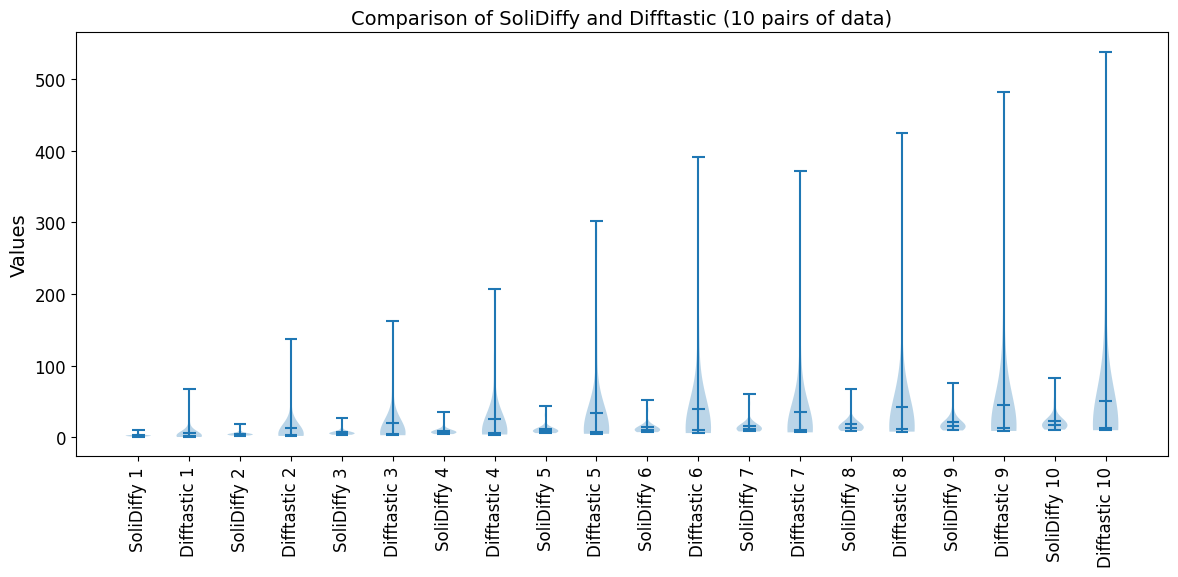

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate your combined values for SoliDiffy and Difftastic (replace these with your actual data)
solidiffy_values = solidiffy_mut_res_combined['combined_list']
difftastic_values = difftastic_mut_res_combined['combined_list']

# Prepare the data
all_data = []
for i in range(10):
    all_data.append(solidiffy_values[i])
    all_data.append(difftastic_values[i])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create positions for the pairs of violin plots
positions = []
for i in range(10):
    positions.append(2 * i + 1)  # Position for SoliDiffy
    positions.append(2 * i + 2)  # Position for Difftastic

# Create labels for each pair
labels = []
for i in range(10):
    labels.append(f'SoliDiffy {i+1}')
    labels.append(f'Difftastic {i+1}')

# Plot the violin plots
ax.violinplot(all_data, positions=positions, showmeans=True, showmedians=True)

# Customize the plot
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=90)
ax.set_title('Comparison of SoliDiffy and Difftastic (10 pairs of data)')
ax.set_ylabel('Values')

# Show the plot
plt.tight_layout()
plt.show()


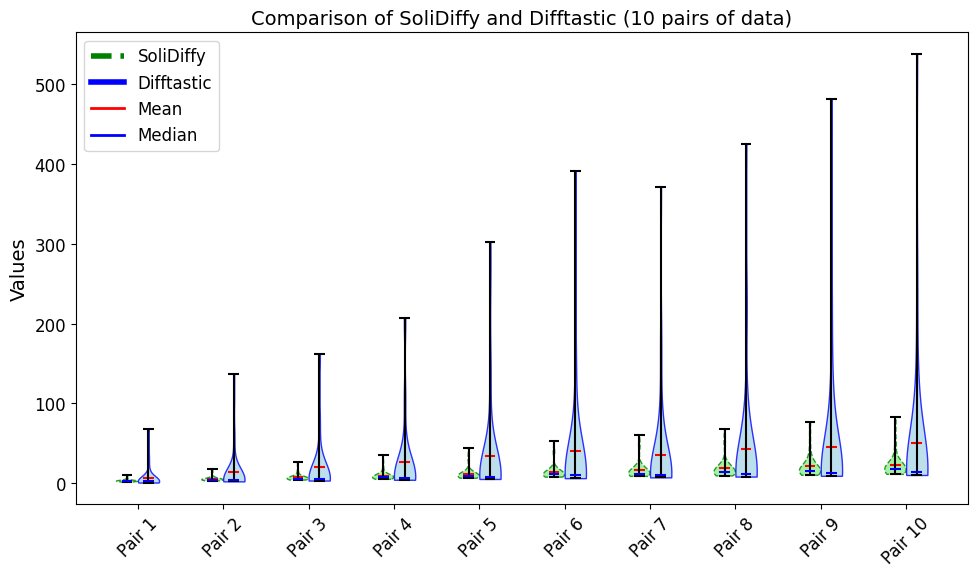

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Simulate your combined values for SoliDiffy and Difftastic (replace these with your actual data)
solidiffy_values = solidiffy_mut_res_combined['combined_list']
difftastic_values = difftastic_mut_res_combined['combined_list']

# Prepare the data
all_data = []
for i in range(10):
    all_data.append(solidiffy_values[i])
    all_data.append(difftastic_values[i])

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create positions for the pairs of violin plots
positions = []
for i in range(10):
    positions.append(2 * i + 1)  # Position for SoliDiffy
    positions.append(2 * i + 1.5)  # Position for Difftastic (closer to SoliDiffy)

# Create labels for each pair
labels = []
for i in range(10):
    labels.append(f'SoliDiffy {i+1}')
    labels.append(f'Difftastic {i+1}')

# Plot the violin plots with custom colors
parts = ax.violinplot(all_data, positions=positions, showmeans=True, showmedians=True)

# Customize colors for the violins and make them less transparent by increasing alpha
colors = ['lightgreen', 'lightblue']
for i in range(10):
    parts['bodies'][2 * i].set_facecolor(colors[0])  # SoliDiffy (lightgreen)
    parts['bodies'][2 * i].set_alpha(0.8)  # Increase opacity for SoliDiffy
    parts['bodies'][2 * i + 1].set_facecolor(colors[1])  # Difftastic (lightblue)
    parts['bodies'][2 * i + 1].set_alpha(0.8)  # Increase opacity for Difftastic

# Add dashes around Difftastic
for i in range(1, 20, 2):
    parts['bodies'][i].set_edgecolor('blue')
    parts['bodies'][i].set_linestyle('-')

for i in range(0, 20, 2):
    parts['bodies'][i].set_edgecolor('green')
    parts['bodies'][i].set_linestyle('--')

# Set mean and median lines with different colors
mean_color = 'red'  # Color for mean
median_color = 'blue'  # Color for median

for partname in ('cbars', 'cmins', 'cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')  # Set the color for cmin, cmax, cbar lines

# Customize mean and median line colors
parts['cmeans'].set_color(mean_color)  # Mean lines in red
parts['cmedians'].set_color(median_color)  # Median lines in blue

# Customize the plot
ax.set_xticks([2 * i + 1.25 for i in range(10)])  # Adjust x-tick positions between the violins of each pair
ax.set_xticklabels([f'Pair {i+1}' for i in range(10)], rotation=45)
ax.set_title('Comparison of SoliDiffy and Difftastic (10 pairs of data)')
ax.set_ylabel('Values')

# Create custom legend entries
legend_elements = [
    Line2D([0], [0], color='green', linestyle='--', lw=4, label='SoliDiffy'),
    Line2D([0], [0], color='blue', linestyle='-', lw=4, label='Difftastic'),
    Line2D([0], [0], color='red', lw=2, label='Mean'),
    Line2D([0], [0], color='blue', lw=2, label='Median')
]

# Add the legend to the plot
ax.legend(handles=legend_elements, loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
%matplotlib inline

In [ ]:
plt.show()

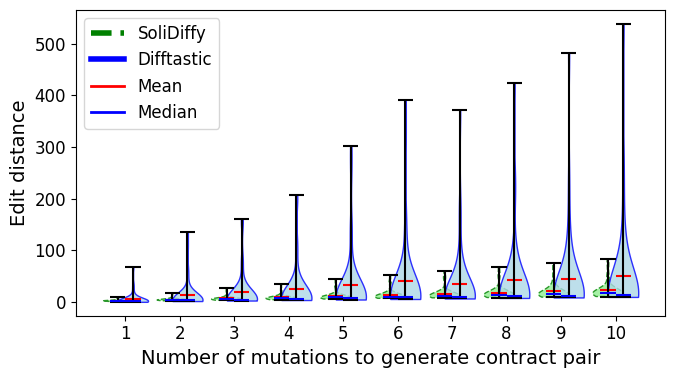

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Simulate your combined values for SoliDiffy and Difftastic (replace these with your actual data)
solidiffy_values = solidiffy_mut_res_combined['combined_list']
difftastic_values = difftastic_mut_res_combined['combined_list']

# Prepare the data
all_data = []
for i in range(10):
    all_data.append(solidiffy_values[i])
    all_data.append(difftastic_values[i])

# Create the plot with size adjusted for a double-column ACM format
fig, ax = plt.subplots(figsize=(6.97, 4.0))  # Width set to 6.97 inches (double column), height adjusted

# Create positions for the pairs of violin plots
# positions = []
# for i in range(10):
#     positions.append(2 * i + 1)  # Position for SoliDiffy
#     positions.append(2 * i + 1.5)  # Position for Difftastic (closer to SoliDiffy)

positions = []
for i in range(10):
    positions.append(1.8 * i)  # Position for SoliDiffy
    positions.append(1.8 * i + 0.5)  # Position for Difftastic (closer to SoliDiffy)

# Create labels for each pair
labels = []
for i in range(10):
    labels.append(f'SoliDiffy {i+1}')
    labels.append(f'Difftastic {i+1}')

# Plot the violin plots with custom colors
parts = ax.violinplot(all_data, positions=positions, showmeans=True, showmedians=True, widths=1)

# Customize colors for the violins and make them less transparent by increasing alpha
colors = ['lightgreen', 'lightblue']
for i in range(10):
    parts['bodies'][2 * i].set_facecolor(colors[0])  # SoliDiffy (lightgreen)
    parts['bodies'][2 * i].set_alpha(0.8)  # Increase opacity for SoliDiffy
    parts['bodies'][2 * i + 1].set_facecolor(colors[1])  # Difftastic (lightblue)
    parts['bodies'][2 * i + 1].set_alpha(0.8)  # Increase opacity for Difftastic

# Add dashes around Difftastic
for i in range(1, 20, 2):
    parts['bodies'][i].set_edgecolor('blue')
    parts['bodies'][i].set_linestyle('-')

for i in range(0, 20, 2):
    parts['bodies'][i].set_edgecolor('green')
    parts['bodies'][i].set_linestyle('--')

# Set mean and median lines with different colors
mean_color = 'red'  # Color for mean
median_color = 'blue'  # Color for median

for partname in ('cbars', 'cmins', 'cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('black')  # Set the color for cmin, cmax, cbar lines

# Customize mean and median line colors
parts['cmeans'].set_color(mean_color)  # Mean lines in red
parts['cmeans'].set_linestyle('-')  # Dashed line style for mean
parts['cmedians'].set_color(median_color)  # Median lines in blue

# Customize the plot
#ax.set_xticks([2 * i + 1.25 for i in range(10)])  # Adjust x-tick positions between the violins of each pair
ax.set_xticks([1.8 * i + 0.25 for i in range(10)])  # Adjust x-tick positions between the violins of each pair
ax.set_xticklabels([f'{i+1}' for i in range(10)], rotation=0, ha='center')

ax.set_ylabel('Edit distance')
ax.set_xlabel('Number of mutations to generate contract pair')

# Create custom legend entries
legend_elements = [
    Line2D([0], [0], color='green', linestyle='--', lw=4, label='SoliDiffy'),
    Line2D([0], [0], color='blue', linestyle='-', lw=4, label='Difftastic'),
    Line2D([0], [0], color='red', lw=2, label='Mean'),
    Line2D([0], [0], color='blue', lw=2, label='Median')
]

# Add the legend to the plot
ax.legend(handles=legend_elements, loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


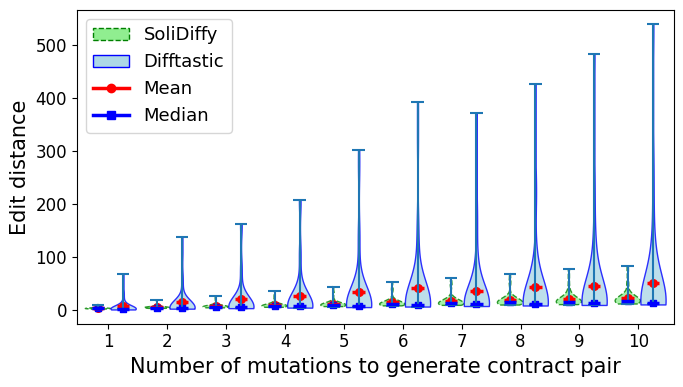

In [99]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Simulate your combined values for SoliDiffy and Difftastic (replace these with your actual data)
solidiffy_values = solidiffy_mut_res_combined['combined_list']
difftastic_values = difftastic_mut_res_combined['combined_list']

# Prepare the data
all_data = []
mean_positions = []
median_positions = []

for i in range(10):
    all_data.append(solidiffy_values[i])
    all_data.append(difftastic_values[i])

    # Calculate mean and median for markers
    mean_positions.append(np.mean(solidiffy_values[i]))
    mean_positions.append(np.mean(difftastic_values[i]))
    median_positions.append(np.median(solidiffy_values[i]))
    median_positions.append(np.median(difftastic_values[i]))

# Create the plot with size adjusted for a double-column ACM format
fig, ax = plt.subplots(figsize=(6.97, 4.0))  # Width set to 6.97 inches (double column), height adjusted

# Create positions for the pairs of violin plots
positions = []
for i in range(10):
    positions.append(2.8 * i)  # Position for SoliDiffy
    positions.append(2.8 * i + 1.2)  # Position for Difftastic (closer to SoliDiffy)

# Create labels for each pair
labels = []
for i in range(10):
    labels.append(f'SoliDiffy {i+1}')
    labels.append(f'Difftastic {i+1}')

# Plot the violin plots with custom colors
parts = ax.violinplot(all_data, positions=positions, showmeans=True, showmedians=True, widths=1.2)

# Customize colors for the violins and make them less transparent by increasing alpha
colors = ['lightgreen', 'lightblue']
for i in range(10):
    parts['bodies'][2 * i].set_facecolor(colors[0])  # SoliDiffy (lightgreen)
    parts['bodies'][2 * i].set_alpha(0.8)  # Increase opacity for SoliDiffy
    parts['bodies'][2 * i + 1].set_facecolor(colors[1])  # Difftastic (lightblue)
    parts['bodies'][2 * i + 1].set_alpha(0.8)  # Increase opacity for Difftastic

# Add dashes around Difftastic
for i in range(1, 20, 2):
    parts['bodies'][i].set_edgecolor('blue')
    parts['bodies'][i].set_linestyle('-')

for i in range(0, 20, 2):
    parts['bodies'][i].set_edgecolor('green')
    parts['bodies'][i].set_linestyle('--')

# Set mean and median lines with different colors and increase their visibility
mean_color = 'red'  # Color for mean
median_color = 'blue'  # Color for median

parts['cmeans'].set_color(mean_color)  # Mean lines in red
parts['cmeans'].set_linestyle('-')  # Solid line style for mean
parts['cmeans'].set_linewidth(2.5)  # Thicker mean line

parts['cmedians'].set_color(median_color)  # Median lines in blue
parts['cmedians'].set_linewidth(2.5)  # Thicker median line

# Scatter markers for mean and median
ax.scatter(positions, mean_positions, color=mean_color, marker='o', s=30, zorder=1, label='Mean')  # Mean markers
ax.scatter(positions, median_positions, color=median_color, marker='s', s=15, zorder=1, label='Median')  # Median markers

# Customize the plot
ax.set_xticks([2.8 * i + 0.5 for i in range(10)])  # Adjust x-tick positions between the violins of each pair
ax.set_xticklabels([f'{i+1}' for i in range(10)], rotation=0, ha='center')

ax.set_ylabel('Edit distance', fontsize=15)  # Set font size for y-axis label
ax.set_xlabel('Number of mutations to generate contract pair', fontsize=15)  # Set font size for x-axis label

# Adjust the x-axis limits to remove extra space
ax.set_xlim(min(positions) - 1, max(positions) + 1)

# Create custom legend entries with Patch for box background
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='green', linestyle='--', label='SoliDiffy'),
    Patch(facecolor='lightblue', edgecolor='blue', linestyle='-', label='Difftastic'),
    Line2D([0], [0], color='red', lw=2.5, marker='o', label='Mean'),
    Line2D([0], [0], color='blue', lw=2.5, marker='s', label='Median')
]

# Add the legend to the plot
ax.legend(handles=legend_elements, loc='upper left', fontsize=13)  # Set font size for legend

# Show the plot
plt.tight_layout()
plt.savefig('figures/edit_distances_violin_custom.pdf', format='pdf', bbox_inches='tight')  # Save the plot as PDF
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these functions are defined elsewhere in your code
# from your_module import load_pickles, remove_mut_operators, setup, analyze_diffs, calc_corr, bar_by_mut_plot

num_mut = 10
pickles = load_pickles()

remove_mut_operators(pickles, ["AVR", "SCEC"])

GT_res_dict = setup(num_mut)
analyze_diffs(pickles["GT"], GT_res_dict, num_mut)

difft_res_dict = setup(num_mut)
analyze_diffs(pickles["difft"], difft_res_dict, num_mut)

# Combine all values from the different mutation categories
def combine_mutation_results(mut_res_dict):
    combined_values = []
    for key, values in mut_res_dict.items():
        combined_values.extend(values)
    return combined_values

# Combine values for GT and Difft
gt_mut_res_combined = combine_mutation_results(GT_res_dict["mut_res"])
difft_mut_res_combined = combine_mutation_results(difft_res_dict["mut_res"])

# Filter out values greater than 300
gt_mut_res_combined = [x for x in gt_mut_res_combined]# if x <= 300]
difft_mut_res_combined = [x for x in difft_mut_res_combined]# if x <= 300]

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Violin plot
data = [gt_mut_res_combined, difft_mut_res_combined]
violin_parts = ax.violinplot(data, showmeans=False, showmedians=False)

# Customize violin colors
colors = ['lightgreen', 'lightblue']  # GT and Difft different colors
for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Add mean and median lines
means = [np.mean(gt_mut_res_combined), np.mean(difft_mut_res_combined)]
medians = [np.median(gt_mut_res_combined), np.median(difft_mut_res_combined)]

# Median lines (solid)
ax.hlines(medians, [0.85, 1.85], [1.15, 2.15], colors='red', linestyles='-', lw=2, label='Median')

# Mean lines (dashed)
ax.hlines(means, [0.85, 1.85], [1.15, 2.15], colors='blue', linestyles='--', lw=2, label='Mean')

# Set x-axis labels
ax.set_xticks([1, 2])
ax.set_xticklabels(['SoliDiffy', 'Difftastic'])
ax.set_ylabel('Edit Distances')

# Add legend
mean_line = plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean')
median_line = plt.Line2D([0], [0], color='red', lw=2, linestyle='-', label='Median')
ax.legend(handles=[mean_line, median_line], loc='upper left')

# Save the plot
plt.savefig('figures/edit_distances_violin.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()  # Close the figure


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these functions are defined elsewhere in your code
# from your_module import load_pickles, remove_mut_operators, setup, analyze_diffs, calc_corr, bar_by_mut_plot
plt.rcParams.update({'font.size': 11})

num_mut = 10
pickles = load_pickles()

remove_mut_operators(pickles, ["AVR", "SCEC"])

GT_res_dict = setup(num_mut)
analyze_diffs(pickles["GT"], GT_res_dict, num_mut)

difft_res_dict = setup(num_mut)
analyze_diffs(pickles["difft"], difft_res_dict, num_mut)

# Combine all values from the different mutation categories
def combine_mutation_results(mut_res_dict):
    combined_values = []
    for key, values in mut_res_dict.items():
        combined_values.extend(values)
    return combined_values

# Combine values for GT and Difft
gt_mut_res_combined = combine_mutation_results(GT_res_dict["mut_res"])
difft_mut_res_combined = combine_mutation_results(difft_res_dict["mut_res"])

# Filter out values greater than 300
gt_mut_res_combined = [x for x in gt_mut_res_combined]# if x <= 300]
difft_mut_res_combined = [x for x in difft_mut_res_combined]# if x <= 300]

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Violin plot
data = [gt_mut_res_combined, difft_mut_res_combined]
violin_parts = ax.violinplot(data, showmeans=False, showmedians=False)

# Customize violin colors
colors = ['lightgreen', 'lightblue']  # GT and Difft different colors
for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Add mean and median lines
means = [np.mean(gt_mut_res_combined), np.mean(difft_mut_res_combined)]
medians = [np.median(gt_mut_res_combined), np.median(difft_mut_res_combined)]

# Median lines (solid)
ax.hlines(medians, [0.85, 1.85], [1.15, 2.15], colors='red', linestyles='-', lw=2, label='Median')

# Mean lines (dashed)
ax.hlines(means, [0.85, 1.85], [1.15, 2.15], colors='blue', linestyles='--', lw=2, label='Mean')

# Set x-axis labels
ax.set_xticks([1, 2])
ax.set_xticklabels(['SoliDiffy', 'Difftastic'])
ax.set_ylabel('Edit Distances')

# Add legend
mean_line = plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean')
median_line = plt.Line2D([0], [0], color='red', lw=2, linestyle='-', label='Median')
ax.legend(handles=[mean_line, median_line], loc='upper left')

# Save the plot
plt.savefig('figures/edit_distances_violin.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()  # Close the figure


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these functions are defined elsewhere in your code
# from your_module import load_pickles, remove_mut_operators, setup, analyze_diffs, calc_corr, bar_by_mut_plot

num_mut = 10
pickles = load_pickles()

remove_mut_operators(pickles, ["AVR", "SCEC"])

GT_res_dict = setup(num_mut)
analyze_diffs(pickles["GT"], GT_res_dict, num_mut)

difft_res_dict = setup(num_mut)
analyze_diffs(pickles["difft"], difft_res_dict, num_mut)

# For clarity, we're assuming that GT_res_dict["mut_res"] and difft_res_dict["mut_res"] are dictionaries
# where keys are mutation operator names and values are lists of edit distances.

# Mutation operators (assuming you have 10 operators)
mutation_operators = list(GT_res_dict["mut_res"].keys())[:10]  # Take the first 10 operators

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

# Prepare the data for the violin plot
data = []

for operator in mutation_operators:
    gt_data = GT_res_dict["mut_res"][operator]  # SoliDiffy data for this operator
    difft_data = difft_res_dict["mut_res"][operator]  # Difftastic data for this operator
    data.append(gt_data)
    data.append(difft_data)

# Violin plot
positions = np.arange(1, len(data) + 1)
violin_parts = ax.violinplot(data, positions=positions, showmeans=False, showmedians=False)

# Customize violin colors (alternating colors for SoliDiffy and Difftastic)
colors = ['lightgreen', 'lightblue']
for i, pc in enumerate(violin_parts['bodies']):
    color_index = i % 2  # Alternate colors for each pair
    pc.set_facecolor(colors[color_index])
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Add mean and median lines for each violin
for i in range(len(data)):
    mean = np.mean(data[i])
    median = np.median(data[i])
    # Add mean lines (dashed)
    ax.hlines(mean, positions[i] - 0.25, positions[i] + 0.25, colors='blue', linestyles='--', lw=1.5)
    # Add median lines (solid)
    ax.hlines(median, positions[i] - 0.25, positions[i] + 0.25, colors='red', linestyles='-', lw=1.5)

# Set x-axis labels
ax.set_xticks(positions)
xtick_labels = []
for operator in mutation_operators:
    xtick_labels.append(f'{operator}\nSoliDiffy')
    xtick_labels.append(f'{operator}\nDifftastic')
ax.set_xticklabels(xtick_labels, rotation=45, ha='right')
ax.set_ylabel('Edit Distances')

# Add legend
mean_line = plt.Line2D([0], [0], color='blue', lw=1.5, linestyle='--', label='Mean')
median_line = plt.Line2D([0], [0], color='red', lw=1.5, linestyle='-', label='Median')
ax.legend(handles=[mean_line, median_line], loc='upper right')

# Save the plot
plt.tight_layout()
plt.savefig('figures/edit_distances_10_operators_violin.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()  # Close the figure


In [ ]:

import matplotlib.pyplot as plt
import numpy as np


num_mut = 10
pickles = load_pickles()


GT_res_dict = setup(num_mut)
analyze_diffs(pickles["GT"], GT_res_dict, num_mut)

difft_res_dict = setup(num_mut)
analyze_diffs(pickles["difft"], difft_res_dict, num_mut)


box_plot((GT_res_dict["mut_res"], difft_res_dict["mut_res"]), 0.15)
plt.title('')  # Remove title
plt.savefig('figures/edit_distances.pdf', format='pdf', bbox_inches='tight')  # Save the box plot as PDF

plt.close()  # Close the figure



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def enhanced_box_plot(data, width=0.15):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create the box plot with custom settings
    box = ax.boxplot(data, patch_artist=True, widths=width, showmeans=True,
                     meanline=True, showfliers=False, boxprops=dict(facecolor='lightblue', color='blue'),
                     medianprops=dict(color='red', linewidth=2), meanprops=dict(color='green', linewidth=2))

    # Set axis labels and title
    ax.set_title('Distribution of Mutation Results Across Tools', fontsize=14, fontweight='bold')
    ax.set_xlabel('Tools', fontsize=12)
    ax.set_ylabel('Edit Distances', fontsize=12)
    
    # Set x-axis tick labels
    ax.set_xticklabels(['GT', 'Difftastic'], fontsize=12)

    # Add a grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add a legend to explain mean and median
    ax.legend([box["medians"][0], box["means"][0]], ['Median', 'Mean'], loc='upper right', fontsize=10)

    # Adjust the layout for better presentation
    plt.tight_layout()

    # Save the box plot as PDF
    plt.savefig('figures/edit_distances_enhanced.pdf', format='pdf', bbox_inches='tight')
    plt.close()

# Assuming the functions `load_pickles`, `setup`, and `analyze_diffs` are already defined
num_mut = 10
pickles = load_pickles()

GT_res_dict = setup(num_mut)
analyze_diffs(pickles["GT"], GT_res_dict, num_mut)

difft_res_dict = setup(num_mut)
analyze_diffs(pickles["difft"], difft_res_dict, num_mut)

# Call the enhanced box plot function
enhanced_box_plot([GT_res_dict["mut_res"], difft_res_dict["mut_res"]], 0.15)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def enhanced_comparison_box_plot_all_metrics(gt_dict, difft_dict, width=0.3):
    # Prepare data for all metrics, each mutation will have metrics from GT and difft plotted side by side
    metrics = list(gt_dict.keys())  # List of all metric names (DLR, PKD, etc.)
    num_metrics = len(metrics)
    
    # Determine the number of mutations based on the smallest list length to avoid out-of-range errors
    num_mutations = min(len(gt_dict[metrics[0]]), len(difft_dict[metrics[0]]))
    
    # Prepare the data for each mutation index, across all metrics
    combined_data = []
    labels = []
    
    for i in range(num_mutations):
        gt_mutation_data = [gt_dict[metric][i] for metric in metrics if len(gt_dict[metric]) > i]  # GT values for each metric at mutation i
        difft_mutation_data = [difft_dict[metric][i] for metric in metrics if len(difft_dict[metric]) > i]  # Difft values for each metric at mutation i
        
        if gt_mutation_data and difft_mutation_data:  # Ensure there is data to plot
            combined_data.append(gt_mutation_data)
            combined_data.append(difft_mutation_data)
        
            # Add labels for this mutation (GT and Difft for each metric)
            labels.extend([f'GT {metric}' for metric in metrics])
            labels.extend([f'Difft {metric}' for metric in metrics])
    
    # Create positions for each box plot, with width spacing
    positions = np.arange(len(combined_data)) * (width + 0.1)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create the box plot
    box = ax.boxplot(combined_data, positions=positions, patch_artist=True, widths=width, showmeans=True,
                     meanline=True, showfliers=False,
                     boxprops=dict(facecolor='lightblue', color='blue'),
                     medianprops=dict(color='red', linewidth=2), meanprops=dict(color='green', linewidth=2))

    # Set axis labels and title
    ax.set_title(f'Comparison of GT and Difftastic Across All Metrics', fontsize=16, fontweight='bold')
    ax.set_xlabel('Metrics (Grouped by Mutation Index)', fontsize=14)
    ax.set_ylabel('Edit Distances', fontsize=14)
    
    # Set x-axis tick labels
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, rotation=90, fontsize=10)

    # Add a grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Adjust the layout for better presentation
    plt.tight_layout()

    # Save the box plot as PDF
    plt.savefig('figures/comparison_all_metrics.pdf', format='pdf', bbox_inches='tight')
    plt.close()

# Assuming the functions `load_pickles`, `setup`, and `analyze_diffs` are already defined
num_mut = 10
pickles = load_pickles()

GT_res_dict = setup(num_mut)
analyze_diffs(pickles["GT"], GT_res_dict, num_mut)

difft_res_dict = setup(num_mut)
analyze_diffs(pickles["difft"], difft_res_dict, num_mut)

# Call the comparison box plot function for all metrics
enhanced_comparison_box_plot_all_metrics(GT_res_dict["mut_res"], difft_res_dict["mut_res"], 0.15)
